In [4]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, depth, num_heads):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)  # in_channels set to 1 for grayscale
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1)  # Output a single value for regression
        )

    def forward(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer_encoder(x)
        x = self.regression_head(x[:, 0])
        return x

# Example usage
model = VisionTransformer(img_size=(216, 8), patch_size=8, embed_dim=128, depth=12, num_heads=4)
dummy_input = torch.randn(1, 1, 216, 8)  # Grayscale image with shape [batch_size, channels, height, width]
output = model(dummy_input)
print(output.shape)  # Expected output shape: [1, 1] for regression


torch.Size([1, 1])


In [ ]:
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data_tensor = data_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        sample = self.data_tensor[idx]
        label = self.labels_tensor[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label
    


# Function to pad the image to the nearest multiple of patch_size_h and patch_size_w
def pad_image(image, patch_size_h, patch_size_w):
    B, C, H, W = image.shape
    pad_h = (patch_size_h - (H % patch_size_h)) % patch_size_h
    pad_w = (patch_size_w - (W % patch_size_w)) % patch_size_w

    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_image = F.pad(image, padding)
    return padded_image



# Define any required transformations
transform = transforms.Compose([
    # Add any transformations you need here
])

train_norm = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_train_02292024.npy'
train_yield = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_yield_train.npy'

data_train = np.load(train_norm)
data_tensor = torch.from_numpy(data_train)
data_tensor = data_tensor.permute(2, 1, 0)
data_tensor = data_tensor.unsqueeze(1)

train_label = np.load(train_yield)
label_tensor = torch.from_numpy(train_label)

data_tensor = pad_image(data_tensor, 216, 8)  # Pad to [93056, 1, 216, 8]
dataset = CustomTensorDataset(data_tensor=data_tensor, labels_tensor=label_tensor, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, depth, num_heads):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)  # in_channels set to 1 for grayscale
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1)  # Output a single value for regression
        )

    def forward(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer_encoder(x)
        x = self.regression_head(x[:, 0])
        return x

class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data_tensor = data_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        sample = self.data_tensor[idx]
        label = self.labels_tensor[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Function to pad the image to the nearest multiple of patch_size_h and patch_size_w
def pad_image(image, patch_size_h, patch_size_w):
    B, C, H, W = image.shape
    pad_h = (patch_size_h - (H % patch_size_h)) % patch_size_h
    pad_w = (patch_size_w - (W % patch_size_w)) % patch_size_w

    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_image = F.pad(image, padding)
    return padded_image

# Define any required transformations
transform = transforms.Compose([
    # Add any transformations you need here
])

train_norm = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_train_02292024.npy'
train_yield = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_yield_train.npy'

data_train = np.load(train_norm)
data_tensor = torch.from_numpy(data_train).float()  # Convert to float
data_tensor = data_tensor.permute(2, 1, 0)
data_tensor = data_tensor.unsqueeze(1)

train_label = np.load(train_yield)
label_tensor = torch.from_numpy(train_label).float()  # Convert to float

data_tensor = pad_image(data_tensor, 216, 8)  # Pad to [batch_size, 1, 216, 8]
dataset = CustomTensorDataset(data_tensor=data_tensor, labels_tensor=label_tensor, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Example usage of the model
model = VisionTransformer(img_size=(216, 8), patch_size=8, embed_dim=128, depth=12, num_heads=4)

# Iterate through the dataloader
for batch in dataloader:
    inputs, targets = batch
    outputs = model(inputs)
    print(outputs.shape)  # Expected output shape: [batch_size, 1] for regression
    break


torch.Size([64, 1])


Device: cuda:0
Epoch 1/10


Training:   2%|▏         | 16/873 [00:00<00:32, 26.08it/s]

  Batch 10/873, Training Loss: 0.0300


Training:   3%|▎         | 24/873 [00:01<00:27, 30.68it/s]

  Batch 20/873, Training Loss: 0.0474


Training:   4%|▍         | 36/873 [00:01<00:24, 34.40it/s]

  Batch 30/873, Training Loss: 0.0269


Training:   5%|▌         | 44/873 [00:01<00:24, 34.04it/s]

  Batch 40/873, Training Loss: 0.0353


Training:   6%|▋         | 56/873 [00:02<00:22, 35.64it/s]

  Batch 50/873, Training Loss: 0.0247


Training:   7%|▋         | 64/873 [00:02<00:22, 35.43it/s]

  Batch 60/873, Training Loss: 0.0207


Training:   9%|▊         | 76/873 [00:02<00:23, 34.43it/s]

  Batch 70/873, Training Loss: 0.0227


Training:  10%|▉         | 84/873 [00:02<00:22, 35.18it/s]

  Batch 80/873, Training Loss: 0.0248


Training:  11%|█         | 96/873 [00:03<00:21, 35.33it/s]

  Batch 90/873, Training Loss: 0.0198


Training:  12%|█▏        | 104/873 [00:03<00:21, 35.44it/s]

  Batch 100/873, Training Loss: 0.0153


Training:  13%|█▎        | 116/873 [00:03<00:21, 35.23it/s]

  Batch 110/873, Training Loss: 0.0190


Training:  14%|█▍        | 124/873 [00:03<00:21, 35.28it/s]

  Batch 120/873, Training Loss: 0.0250


Training:  16%|█▌        | 136/873 [00:04<00:20, 36.16it/s]

  Batch 130/873, Training Loss: 0.0234


Training:  16%|█▋        | 144/873 [00:04<00:20, 35.28it/s]

  Batch 140/873, Training Loss: 0.0115


Training:  18%|█▊        | 156/873 [00:04<00:20, 35.24it/s]

  Batch 150/873, Training Loss: 0.0133


Training:  19%|█▉        | 164/873 [00:05<00:20, 34.97it/s]

  Batch 160/873, Training Loss: 0.0131


Training:  20%|██        | 176/873 [00:05<00:22, 31.59it/s]

  Batch 170/873, Training Loss: 0.0205


Training:  21%|██        | 184/873 [00:05<00:21, 32.55it/s]

  Batch 180/873, Training Loss: 0.0164


Training:  22%|██▏       | 196/873 [00:06<00:19, 34.14it/s]

  Batch 190/873, Training Loss: 0.0201


Training:  23%|██▎       | 204/873 [00:06<00:21, 31.07it/s]

  Batch 200/873, Training Loss: 0.0110


Training:  25%|██▍       | 216/873 [00:06<00:20, 32.00it/s]

  Batch 210/873, Training Loss: 0.0126


Training:  26%|██▌       | 224/873 [00:06<00:19, 33.23it/s]

  Batch 220/873, Training Loss: 0.0131


Training:  27%|██▋       | 232/873 [00:07<00:20, 30.69it/s]

  Batch 230/873, Training Loss: 0.0182


Training:  28%|██▊       | 244/873 [00:07<00:20, 31.38it/s]

  Batch 240/873, Training Loss: 0.0128


Training:  29%|██▉       | 256/873 [00:07<00:18, 34.07it/s]

  Batch 250/873, Training Loss: 0.0173


Training:  30%|███       | 264/873 [00:08<00:17, 34.72it/s]

  Batch 260/873, Training Loss: 0.0141


Training:  32%|███▏      | 276/873 [00:08<00:17, 34.57it/s]

  Batch 270/873, Training Loss: 0.0134


Training:  33%|███▎      | 284/873 [00:08<00:16, 34.90it/s]

  Batch 280/873, Training Loss: 0.0177


Training:  34%|███▍      | 296/873 [00:09<00:16, 35.50it/s]

  Batch 290/873, Training Loss: 0.0120


Training:  35%|███▍      | 304/873 [00:09<00:16, 35.34it/s]

  Batch 300/873, Training Loss: 0.0115


Training:  36%|███▌      | 316/873 [00:09<00:15, 35.06it/s]

  Batch 310/873, Training Loss: 0.0165


Training:  37%|███▋      | 324/873 [00:09<00:15, 35.40it/s]

  Batch 320/873, Training Loss: 0.0183


Training:  38%|███▊      | 336/873 [00:10<00:14, 35.92it/s]

  Batch 330/873, Training Loss: 0.0087


Training:  39%|███▉      | 344/873 [00:10<00:14, 35.47it/s]

  Batch 340/873, Training Loss: 0.0147


Training:  41%|████      | 356/873 [00:10<00:14, 35.21it/s]

  Batch 350/873, Training Loss: 0.0142


Training:  42%|████▏     | 364/873 [00:11<00:15, 33.03it/s]

  Batch 360/873, Training Loss: 0.0125


Training:  43%|████▎     | 372/873 [00:11<00:15, 31.35it/s]

  Batch 370/873, Training Loss: 0.0128


Training:  44%|████▍     | 384/873 [00:11<00:15, 32.26it/s]

  Batch 380/873, Training Loss: 0.0115


Training:  45%|████▌     | 396/873 [00:12<00:13, 34.68it/s]

  Batch 390/873, Training Loss: 0.0125


Training:  46%|████▋     | 404/873 [00:12<00:13, 34.60it/s]

  Batch 400/873, Training Loss: 0.0121


Training:  48%|████▊     | 416/873 [00:12<00:13, 34.25it/s]

  Batch 410/873, Training Loss: 0.0110


Training:  49%|████▊     | 424/873 [00:12<00:12, 34.81it/s]

  Batch 420/873, Training Loss: 0.0122


Training:  50%|████▉     | 436/873 [00:13<00:12, 34.89it/s]

  Batch 430/873, Training Loss: 0.0133


Training:  51%|█████     | 444/873 [00:13<00:12, 35.00it/s]

  Batch 440/873, Training Loss: 0.0173


Training:  52%|█████▏    | 456/873 [00:13<00:12, 34.33it/s]

  Batch 450/873, Training Loss: 0.0088


Training:  53%|█████▎    | 464/873 [00:14<00:11, 34.86it/s]

  Batch 460/873, Training Loss: 0.0130


Training:  55%|█████▍    | 476/873 [00:14<00:11, 33.47it/s]

  Batch 470/873, Training Loss: 0.0137


Training:  55%|█████▌    | 484/873 [00:14<00:12, 32.20it/s]

  Batch 480/873, Training Loss: 0.0105


Training:  57%|█████▋    | 496/873 [00:15<00:10, 34.91it/s]

  Batch 490/873, Training Loss: 0.0133


Training:  58%|█████▊    | 504/873 [00:15<00:10, 35.66it/s]

  Batch 500/873, Training Loss: 0.0139


Training:  59%|█████▉    | 516/873 [00:15<00:10, 34.94it/s]

  Batch 510/873, Training Loss: 0.0099


Training:  60%|██████    | 524/873 [00:15<00:09, 35.56it/s]

  Batch 520/873, Training Loss: 0.0097


Training:  61%|██████▏   | 536/873 [00:16<00:09, 36.18it/s]

  Batch 530/873, Training Loss: 0.0103


Training:  62%|██████▏   | 544/873 [00:16<00:09, 36.54it/s]

  Batch 540/873, Training Loss: 0.0121


Training:  64%|██████▎   | 556/873 [00:16<00:08, 35.44it/s]

  Batch 550/873, Training Loss: 0.0132


Training:  65%|██████▍   | 564/873 [00:16<00:08, 36.17it/s]

  Batch 560/873, Training Loss: 0.0106


Training:  66%|██████▌   | 576/873 [00:17<00:08, 34.77it/s]

  Batch 570/873, Training Loss: 0.0132


Training:  67%|██████▋   | 584/873 [00:17<00:08, 32.45it/s]

  Batch 580/873, Training Loss: 0.0185


Training:  68%|██████▊   | 592/873 [00:17<00:08, 31.81it/s]

  Batch 590/873, Training Loss: 0.0163


Training:  69%|██████▉   | 604/873 [00:18<00:08, 33.19it/s]

  Batch 600/873, Training Loss: 0.0123


Training:  71%|███████   | 616/873 [00:18<00:07, 35.36it/s]

  Batch 610/873, Training Loss: 0.0109


Training:  71%|███████▏  | 624/873 [00:18<00:07, 34.14it/s]

  Batch 620/873, Training Loss: 0.0112


Training:  73%|███████▎  | 636/873 [00:19<00:06, 35.01it/s]

  Batch 630/873, Training Loss: 0.0098


Training:  74%|███████▍  | 644/873 [00:19<00:06, 34.93it/s]

  Batch 640/873, Training Loss: 0.0101


Training:  75%|███████▌  | 656/873 [00:19<00:06, 34.16it/s]

  Batch 650/873, Training Loss: 0.0119


Training:  76%|███████▌  | 664/873 [00:19<00:05, 35.21it/s]

  Batch 660/873, Training Loss: 0.0103


Training:  77%|███████▋  | 676/873 [00:20<00:06, 32.69it/s]

  Batch 670/873, Training Loss: 0.0122


Training:  78%|███████▊  | 684/873 [00:20<00:05, 34.25it/s]

  Batch 680/873, Training Loss: 0.0132


Training:  80%|███████▉  | 696/873 [00:20<00:05, 34.83it/s]

  Batch 690/873, Training Loss: 0.0134


Training:  81%|████████  | 704/873 [00:21<00:04, 35.14it/s]

  Batch 700/873, Training Loss: 0.0133


Training:  82%|████████▏ | 716/873 [00:21<00:04, 35.86it/s]

  Batch 710/873, Training Loss: 0.0147


Training:  83%|████████▎ | 724/873 [00:21<00:04, 34.28it/s]

  Batch 720/873, Training Loss: 0.0140


Training:  84%|████████▍ | 737/873 [00:21<00:03, 36.29it/s]

  Batch 730/873, Training Loss: 0.0147


Training:  85%|████████▌ | 745/873 [00:22<00:03, 36.17it/s]

  Batch 740/873, Training Loss: 0.0121


Training:  87%|████████▋ | 757/873 [00:22<00:03, 36.41it/s]

  Batch 750/873, Training Loss: 0.0125


Training:  88%|████████▊ | 765/873 [00:22<00:03, 34.96it/s]

  Batch 760/873, Training Loss: 0.0104


Training:  89%|████████▊ | 773/873 [00:22<00:02, 33.63it/s]

  Batch 770/873, Training Loss: 0.0090


Training:  90%|████████▉ | 785/873 [00:23<00:02, 36.30it/s]

  Batch 780/873, Training Loss: 0.0154


Training:  91%|█████████ | 793/873 [00:23<00:02, 35.43it/s]

  Batch 790/873, Training Loss: 0.0125


Training:  92%|█████████▏| 805/873 [00:23<00:01, 34.77it/s]

  Batch 800/873, Training Loss: 0.0092


Training:  93%|█████████▎| 814/873 [00:24<00:01, 37.02it/s]

  Batch 810/873, Training Loss: 0.0130


Training:  95%|█████████▍| 828/873 [00:24<00:01, 39.36it/s]

  Batch 820/873, Training Loss: 0.0116


Training:  96%|█████████▌| 836/873 [00:24<00:00, 38.28it/s]

  Batch 830/873, Training Loss: 0.0138


Training:  97%|█████████▋| 845/873 [00:24<00:00, 39.34it/s]

  Batch 840/873, Training Loss: 0.0145


Training:  98%|█████████▊| 854/873 [00:25<00:00, 37.17it/s]

  Batch 850/873, Training Loss: 0.0112


Training:  99%|█████████▉| 867/873 [00:25<00:00, 36.27it/s]

  Batch 860/873, Training Loss: 0.0128


Training: 100%|█████████▉| 871/873 [00:25<00:00, 34.96it/s]

  Batch 870/873, Training Loss: 0.0119


Validation:  10%|▉         | 29/291 [00:00<00:04, 61.96it/s]

  Batch 10/291, Validation Loss: 0.0086
  Batch 20/291, Validation Loss: 0.0086
  Batch 30/291, Validation Loss: 0.0091


Validation:  19%|█▉        | 56/291 [00:00<00:02, 95.19it/s]

  Batch 40/291, Validation Loss: 0.0106
  Batch 50/291, Validation Loss: 0.0128
  Batch 60/291, Validation Loss: 0.0140


Validation:  29%|██▊       | 83/291 [00:01<00:01, 112.71it/s]

  Batch 70/291, Validation Loss: 0.0101
  Batch 80/291, Validation Loss: 0.0093
  Batch 90/291, Validation Loss: 0.0063


Validation:  43%|████▎     | 124/291 [00:01<00:01, 126.49it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 110/291, Validation Loss: 0.0120
  Batch 120/291, Validation Loss: 0.0089


Validation:  52%|█████▏    | 152/291 [00:01<00:01, 129.84it/s]

  Batch 130/291, Validation Loss: 0.0102
  Batch 140/291, Validation Loss: 0.0121
  Batch 150/291, Validation Loss: 0.0103


Validation:  62%|██████▏   | 180/291 [00:01<00:00, 127.15it/s]

  Batch 160/291, Validation Loss: 0.0109
  Batch 170/291, Validation Loss: 0.0090
  Batch 180/291, Validation Loss: 0.0106


Validation:  71%|███████▏  | 208/291 [00:02<00:00, 129.03it/s]

  Batch 190/291, Validation Loss: 0.0140
  Batch 200/291, Validation Loss: 0.0129
  Batch 210/291, Validation Loss: 0.0151


Validation:  81%|████████  | 236/291 [00:02<00:00, 130.02it/s]

  Batch 220/291, Validation Loss: 0.0101
  Batch 230/291, Validation Loss: 0.0126
  Batch 240/291, Validation Loss: 0.0121


Validation:  91%|█████████ | 264/291 [00:02<00:00, 130.16it/s]

  Batch 250/291, Validation Loss: 0.0124
  Batch 260/291, Validation Loss: 0.0093
  Batch 270/291, Validation Loss: 0.0095


Validation:  96%|█████████▌| 279/291 [00:02<00:00, 133.26it/s]

  Batch 280/291, Validation Loss: 0.0106
  Batch 290/291, Validation Loss: 0.0115


Epoch [1/10], Training Loss: 0.0482, Validation Loss: 0.0116, Gain: inf
Epoch 2/10


Training:   2%|▏         | 17/873 [00:00<00:32, 26.23it/s]

  Batch 10/873, Training Loss: 0.0106


Training:   3%|▎         | 25/873 [00:01<00:26, 31.75it/s]

  Batch 20/873, Training Loss: 0.0134


Training:   4%|▍         | 38/873 [00:01<00:22, 37.02it/s]

  Batch 30/873, Training Loss: 0.0122


Training:   5%|▌         | 46/873 [00:01<00:22, 37.19it/s]

  Batch 40/873, Training Loss: 0.0090


Training:   6%|▌         | 54/873 [00:01<00:22, 36.24it/s]

  Batch 50/873, Training Loss: 0.0130


Training:   8%|▊         | 66/873 [00:02<00:21, 37.66it/s]

  Batch 60/873, Training Loss: 0.0166


Training:   9%|▊         | 76/873 [00:02<00:20, 39.43it/s]

  Batch 70/873, Training Loss: 0.0141


Training:  10%|▉         | 86/873 [00:02<00:19, 40.85it/s]

  Batch 80/873, Training Loss: 0.0104


Training:  11%|█         | 95/873 [00:02<00:20, 38.90it/s]

  Batch 90/873, Training Loss: 0.0095


Training:  12%|█▏        | 107/873 [00:03<00:19, 38.73it/s]

  Batch 100/873, Training Loss: 0.0141


Training:  13%|█▎        | 117/873 [00:03<00:19, 39.50it/s]

  Batch 110/873, Training Loss: 0.0116


Training:  14%|█▍        | 126/873 [00:03<00:18, 40.02it/s]

  Batch 120/873, Training Loss: 0.0106


Training:  15%|█▌        | 134/873 [00:03<00:19, 38.45it/s]

  Batch 130/873, Training Loss: 0.0131


Training:  16%|█▋        | 144/873 [00:04<00:18, 39.77it/s]

  Batch 140/873, Training Loss: 0.0140


Training:  18%|█▊        | 157/873 [00:04<00:17, 39.84it/s]

  Batch 150/873, Training Loss: 0.0111


Training:  19%|█▉        | 166/873 [00:04<00:17, 39.83it/s]

  Batch 160/873, Training Loss: 0.0138


Training:  20%|█▉        | 174/873 [00:04<00:18, 38.26it/s]

  Batch 170/873, Training Loss: 0.0098


Training:  21%|██▏       | 187/873 [00:05<00:17, 38.88it/s]

  Batch 180/873, Training Loss: 0.0147


Training:  22%|██▏       | 196/873 [00:05<00:16, 40.24it/s]

  Batch 190/873, Training Loss: 0.0127


Training:  24%|██▎       | 206/873 [00:05<00:16, 41.49it/s]

  Batch 200/873, Training Loss: 0.0118


Training:  25%|██▍       | 216/873 [00:06<00:16, 40.61it/s]

  Batch 210/873, Training Loss: 0.0135


Training:  26%|██▌       | 226/873 [00:06<00:15, 41.55it/s]

  Batch 220/873, Training Loss: 0.0119


Training:  27%|██▋       | 236/873 [00:06<00:15, 41.80it/s]

  Batch 230/873, Training Loss: 0.0113


Training:  28%|██▊       | 246/873 [00:06<00:14, 42.12it/s]

  Batch 240/873, Training Loss: 0.0146


Training:  29%|██▉       | 256/873 [00:06<00:15, 39.56it/s]

  Batch 250/873, Training Loss: 0.0085


Training:  30%|███       | 266/873 [00:07<00:14, 41.03it/s]

  Batch 260/873, Training Loss: 0.0133


Training:  32%|███▏      | 276/873 [00:07<00:14, 41.60it/s]

  Batch 270/873, Training Loss: 0.0114


Training:  33%|███▎      | 286/873 [00:07<00:13, 42.15it/s]

  Batch 280/873, Training Loss: 0.0118


Training:  34%|███▍      | 296/873 [00:07<00:14, 40.32it/s]

  Batch 290/873, Training Loss: 0.0152


Training:  35%|███▌      | 306/873 [00:08<00:13, 41.50it/s]

  Batch 300/873, Training Loss: 0.0141


Training:  36%|███▌      | 316/873 [00:08<00:13, 41.72it/s]

  Batch 310/873, Training Loss: 0.0086


Training:  37%|███▋      | 326/873 [00:08<00:12, 42.21it/s]

  Batch 320/873, Training Loss: 0.0116


Training:  38%|███▊      | 336/873 [00:08<00:13, 40.12it/s]

  Batch 330/873, Training Loss: 0.0122


Training:  40%|███▉      | 346/873 [00:09<00:12, 41.33it/s]

  Batch 340/873, Training Loss: 0.0122


Training:  41%|████      | 356/873 [00:09<00:12, 41.76it/s]

  Batch 350/873, Training Loss: 0.0107


Training:  42%|████▏     | 366/873 [00:09<00:12, 42.21it/s]

  Batch 360/873, Training Loss: 0.0099


Training:  43%|████▎     | 376/873 [00:09<00:12, 40.87it/s]

  Batch 370/873, Training Loss: 0.0174


Training:  44%|████▍     | 386/873 [00:10<00:11, 41.37it/s]

  Batch 380/873, Training Loss: 0.0116


Training:  45%|████▌     | 396/873 [00:10<00:11, 42.02it/s]

  Batch 390/873, Training Loss: 0.0117


Training:  47%|████▋     | 406/873 [00:10<00:11, 42.15it/s]

  Batch 400/873, Training Loss: 0.0148


Training:  48%|████▊     | 416/873 [00:10<00:10, 41.78it/s]

  Batch 410/873, Training Loss: 0.0123


Training:  49%|████▉     | 426/873 [00:11<00:10, 40.83it/s]

  Batch 420/873, Training Loss: 0.0109


Training:  50%|████▉     | 436/873 [00:11<00:11, 39.59it/s]

  Batch 430/873, Training Loss: 0.0151


Training:  51%|█████     | 444/873 [00:11<00:11, 38.03it/s]

  Batch 440/873, Training Loss: 0.0138


Training:  52%|█████▏    | 456/873 [00:11<00:11, 36.34it/s]

  Batch 450/873, Training Loss: 0.0115


Training:  53%|█████▎    | 465/873 [00:12<00:10, 38.15it/s]

  Batch 460/873, Training Loss: 0.0123


Training:  54%|█████▍    | 474/873 [00:12<00:10, 39.11it/s]

  Batch 470/873, Training Loss: 0.0108


Training:  56%|█████▌    | 487/873 [00:12<00:09, 38.85it/s]

  Batch 480/873, Training Loss: 0.0110


Training:  57%|█████▋    | 495/873 [00:12<00:10, 36.39it/s]

  Batch 490/873, Training Loss: 0.0102


Training:  58%|█████▊    | 508/873 [00:13<00:09, 38.63it/s]

  Batch 500/873, Training Loss: 0.0067


Training:  59%|█████▉    | 517/873 [00:13<00:08, 39.82it/s]

  Batch 510/873, Training Loss: 0.0140


Training:  60%|██████    | 527/873 [00:13<00:08, 40.37it/s]

  Batch 520/873, Training Loss: 0.0118


Training:  61%|██████▏   | 536/873 [00:13<00:08, 38.44it/s]

  Batch 530/873, Training Loss: 0.0141


Training:  62%|██████▏   | 545/873 [00:14<00:08, 38.20it/s]

  Batch 540/873, Training Loss: 0.0118


Training:  64%|██████▍   | 557/873 [00:14<00:08, 37.40it/s]

  Batch 550/873, Training Loss: 0.0091


Training:  65%|██████▍   | 565/873 [00:14<00:08, 38.13it/s]

  Batch 560/873, Training Loss: 0.0128


Training:  66%|██████▌   | 577/873 [00:15<00:07, 37.13it/s]

  Batch 570/873, Training Loss: 0.0122


Training:  67%|██████▋   | 585/873 [00:15<00:07, 37.41it/s]

  Batch 580/873, Training Loss: 0.0154


Training:  68%|██████▊   | 594/873 [00:15<00:07, 39.15it/s]

  Batch 590/873, Training Loss: 0.0099


Training:  69%|██████▉   | 604/873 [00:15<00:06, 40.57it/s]

  Batch 600/873, Training Loss: 0.0110


Training:  70%|███████   | 614/873 [00:15<00:06, 39.57it/s]

  Batch 610/873, Training Loss: 0.0117


Training:  71%|███████▏  | 624/873 [00:16<00:06, 41.05it/s]

  Batch 620/873, Training Loss: 0.0142


Training:  73%|███████▎  | 634/873 [00:16<00:05, 41.64it/s]

  Batch 630/873, Training Loss: 0.0099


Training:  74%|███████▍  | 644/873 [00:16<00:05, 42.13it/s]

  Batch 640/873, Training Loss: 0.0158


Training:  75%|███████▍  | 654/873 [00:16<00:05, 40.15it/s]

  Batch 650/873, Training Loss: 0.0149


Training:  76%|███████▌  | 664/873 [00:17<00:05, 41.23it/s]

  Batch 660/873, Training Loss: 0.0113


Training:  77%|███████▋  | 674/873 [00:17<00:04, 41.62it/s]

  Batch 670/873, Training Loss: 0.0112


Training:  78%|███████▊  | 684/873 [00:17<00:04, 42.06it/s]

  Batch 680/873, Training Loss: 0.0117


Training:  79%|███████▉  | 694/873 [00:17<00:04, 40.03it/s]

  Batch 690/873, Training Loss: 0.0102


Training:  81%|████████  | 704/873 [00:18<00:04, 41.09it/s]

  Batch 700/873, Training Loss: 0.0106


Training:  82%|████████▏ | 714/873 [00:18<00:03, 41.28it/s]

  Batch 710/873, Training Loss: 0.0104


Training:  83%|████████▎ | 724/873 [00:18<00:03, 41.86it/s]

  Batch 720/873, Training Loss: 0.0100


Training:  84%|████████▍ | 734/873 [00:18<00:03, 40.99it/s]

  Batch 730/873, Training Loss: 0.0138


Training:  85%|████████▌ | 744/873 [00:19<00:03, 40.91it/s]

  Batch 740/873, Training Loss: 0.0139


Training:  86%|████████▋ | 754/873 [00:19<00:02, 41.39it/s]

  Batch 750/873, Training Loss: 0.0092


Training:  88%|████████▊ | 764/873 [00:19<00:02, 41.91it/s]

  Batch 760/873, Training Loss: 0.0103


Training:  89%|████████▊ | 774/873 [00:19<00:02, 41.99it/s]

  Batch 770/873, Training Loss: 0.0113


Training:  90%|████████▉ | 784/873 [00:20<00:02, 40.74it/s]

  Batch 780/873, Training Loss: 0.0097


Training:  91%|█████████ | 794/873 [00:20<00:01, 41.25it/s]

  Batch 790/873, Training Loss: 0.0141


Training:  92%|█████████▏| 804/873 [00:20<00:01, 41.94it/s]

  Batch 800/873, Training Loss: 0.0114


Training:  93%|█████████▎| 814/873 [00:20<00:01, 42.25it/s]

  Batch 810/873, Training Loss: 0.0136


Training:  94%|█████████▍| 824/873 [00:21<00:01, 40.65it/s]

  Batch 820/873, Training Loss: 0.0116


Training:  96%|█████████▌| 834/873 [00:21<00:00, 41.53it/s]

  Batch 830/873, Training Loss: 0.0147


Training:  97%|█████████▋| 844/873 [00:21<00:00, 41.84it/s]

  Batch 840/873, Training Loss: 0.0091


Training:  98%|█████████▊| 854/873 [00:21<00:00, 42.21it/s]

  Batch 850/873, Training Loss: 0.0084


Training:  99%|█████████▉| 864/873 [00:22<00:00, 40.61it/s]

  Batch 860/873, Training Loss: 0.0146


Training: 100%|█████████▉| 869/873 [00:22<00:00, 41.17it/s]

  Batch 870/873, Training Loss: 0.0135


Validation:  10%|▉         | 29/291 [00:00<00:04, 57.09it/s]

  Batch 10/291, Validation Loss: 0.0089
  Batch 20/291, Validation Loss: 0.0089
  Batch 30/291, Validation Loss: 0.0090


Validation:  20%|██        | 59/291 [00:00<00:02, 96.18it/s]

  Batch 40/291, Validation Loss: 0.0111
  Batch 50/291, Validation Loss: 0.0129
  Batch 60/291, Validation Loss: 0.0145


Validation:  31%|███       | 89/291 [00:01<00:01, 118.84it/s]

  Batch 70/291, Validation Loss: 0.0103
  Batch 80/291, Validation Loss: 0.0102
  Batch 90/291, Validation Loss: 0.0069


Validation:  41%|████      | 119/291 [00:01<00:01, 131.07it/s]

  Batch 100/291, Validation Loss: 0.0130
  Batch 110/291, Validation Loss: 0.0126
  Batch 120/291, Validation Loss: 0.0091


Validation:  51%|█████     | 148/291 [00:01<00:01, 130.28it/s]

  Batch 130/291, Validation Loss: 0.0101
  Batch 140/291, Validation Loss: 0.0125
  Batch 150/291, Validation Loss: 0.0105


Validation:  61%|██████    | 178/291 [00:01<00:00, 136.82it/s]

  Batch 160/291, Validation Loss: 0.0113
  Batch 170/291, Validation Loss: 0.0094
  Batch 180/291, Validation Loss: 0.0109


Validation:  71%|███████▏  | 208/291 [00:02<00:00, 139.13it/s]

  Batch 190/291, Validation Loss: 0.0143
  Batch 200/291, Validation Loss: 0.0126
  Batch 210/291, Validation Loss: 0.0154


Validation:  82%|████████▏ | 238/291 [00:02<00:00, 141.10it/s]

  Batch 220/291, Validation Loss: 0.0101
  Batch 230/291, Validation Loss: 0.0124
  Batch 240/291, Validation Loss: 0.0123


Validation:  92%|█████████▏| 268/291 [00:02<00:00, 140.67it/s]

  Batch 250/291, Validation Loss: 0.0124
  Batch 260/291, Validation Loss: 0.0099
  Batch 270/291, Validation Loss: 0.0099


Validation:  97%|█████████▋| 283/291 [00:02<00:00, 133.71it/s]

  Batch 280/291, Validation Loss: 0.0114
  Batch 290/291, Validation Loss: 0.0117


Epoch [2/10], Training Loss: 0.0118, Validation Loss: 0.0119, Gain: -0.0003
Epoch 3/10


Training:   2%|▏         | 16/873 [00:00<00:33, 25.48it/s]

  Batch 10/873, Training Loss: 0.0113


Training:   3%|▎         | 26/873 [00:01<00:25, 33.64it/s]

  Batch 20/873, Training Loss: 0.0127


Training:   4%|▍         | 36/873 [00:01<00:22, 37.83it/s]

  Batch 30/873, Training Loss: 0.0149


Training:   5%|▌         | 46/873 [00:01<00:20, 40.14it/s]

  Batch 40/873, Training Loss: 0.0132


Training:   6%|▋         | 56/873 [00:01<00:20, 39.25it/s]

  Batch 50/873, Training Loss: 0.0087


Training:   8%|▊         | 66/873 [00:02<00:19, 40.88it/s]

  Batch 60/873, Training Loss: 0.0121


Training:   9%|▊         | 76/873 [00:02<00:19, 41.52it/s]

  Batch 70/873, Training Loss: 0.0115


Training:  10%|▉         | 86/873 [00:02<00:18, 41.96it/s]

  Batch 80/873, Training Loss: 0.0144


Training:  11%|█         | 96/873 [00:02<00:19, 39.77it/s]

  Batch 90/873, Training Loss: 0.0120


Training:  12%|█▏        | 106/873 [00:03<00:18, 41.13it/s]

  Batch 100/873, Training Loss: 0.0097


Training:  13%|█▎        | 116/873 [00:03<00:18, 41.57it/s]

  Batch 110/873, Training Loss: 0.0120


Training:  14%|█▍        | 126/873 [00:03<00:17, 42.09it/s]

  Batch 120/873, Training Loss: 0.0102


Training:  16%|█▌        | 136/873 [00:03<00:18, 40.14it/s]

  Batch 130/873, Training Loss: 0.0106


Training:  17%|█▋        | 146/873 [00:04<00:17, 41.17it/s]

  Batch 140/873, Training Loss: 0.0113


Training:  18%|█▊        | 156/873 [00:04<00:17, 41.58it/s]

  Batch 150/873, Training Loss: 0.0109


Training:  19%|█▉        | 166/873 [00:04<00:16, 42.01it/s]

  Batch 160/873, Training Loss: 0.0077


Training:  20%|██        | 176/873 [00:04<00:16, 41.09it/s]

  Batch 170/873, Training Loss: 0.0088


Training:  21%|██▏       | 186/873 [00:04<00:16, 40.72it/s]

  Batch 180/873, Training Loss: 0.0177


Training:  22%|██▏       | 196/873 [00:05<00:16, 41.13it/s]

  Batch 190/873, Training Loss: 0.0127


Training:  24%|██▎       | 206/873 [00:05<00:15, 41.74it/s]

  Batch 200/873, Training Loss: 0.0147


Training:  25%|██▍       | 216/873 [00:05<00:15, 41.81it/s]

  Batch 210/873, Training Loss: 0.0109


Training:  26%|██▌       | 226/873 [00:05<00:15, 40.59it/s]

  Batch 220/873, Training Loss: 0.0126


Training:  27%|██▋       | 236/873 [00:06<00:15, 41.15it/s]

  Batch 230/873, Training Loss: 0.0121


Training:  28%|██▊       | 246/873 [00:06<00:15, 41.75it/s]

  Batch 240/873, Training Loss: 0.0166


Training:  29%|██▉       | 256/873 [00:06<00:14, 41.86it/s]

  Batch 250/873, Training Loss: 0.0094


Training:  30%|███       | 266/873 [00:06<00:15, 40.40it/s]

  Batch 260/873, Training Loss: 0.0112


Training:  32%|███▏      | 276/873 [00:07<00:14, 41.08it/s]

  Batch 270/873, Training Loss: 0.0124


Training:  33%|███▎      | 286/873 [00:07<00:14, 41.72it/s]

  Batch 280/873, Training Loss: 0.0123


Training:  34%|███▍      | 296/873 [00:07<00:13, 41.95it/s]

  Batch 290/873, Training Loss: 0.0161


Training:  35%|███▌      | 306/873 [00:07<00:13, 40.54it/s]

  Batch 300/873, Training Loss: 0.0082


Training:  36%|███▌      | 316/873 [00:08<00:13, 41.27it/s]

  Batch 310/873, Training Loss: 0.0127


Training:  37%|███▋      | 326/873 [00:08<00:13, 41.36it/s]

  Batch 320/873, Training Loss: 0.0133


Training:  38%|███▊      | 336/873 [00:08<00:12, 41.66it/s]

  Batch 330/873, Training Loss: 0.0092


Training:  40%|███▉      | 346/873 [00:08<00:13, 40.36it/s]

  Batch 340/873, Training Loss: 0.0096


Training:  41%|████      | 356/873 [00:09<00:12, 41.27it/s]

  Batch 350/873, Training Loss: 0.0181


Training:  42%|████▏     | 366/873 [00:09<00:12, 41.55it/s]

  Batch 360/873, Training Loss: 0.0143


Training:  43%|████▎     | 376/873 [00:09<00:11, 41.87it/s]

  Batch 370/873, Training Loss: 0.0090


Training:  44%|████▍     | 386/873 [00:09<00:12, 39.96it/s]

  Batch 380/873, Training Loss: 0.0141


Training:  45%|████▌     | 396/873 [00:10<00:11, 41.09it/s]

  Batch 390/873, Training Loss: 0.0115


Training:  47%|████▋     | 406/873 [00:10<00:11, 41.31it/s]

  Batch 400/873, Training Loss: 0.0150


Training:  48%|████▊     | 416/873 [00:10<00:10, 41.64it/s]

  Batch 410/873, Training Loss: 0.0081


Training:  49%|████▉     | 426/873 [00:10<00:11, 39.63it/s]

  Batch 420/873, Training Loss: 0.0130


Training:  50%|████▉     | 436/873 [00:11<00:10, 40.78it/s]

  Batch 430/873, Training Loss: 0.0112


Training:  51%|█████     | 446/873 [00:11<00:10, 41.27it/s]

  Batch 440/873, Training Loss: 0.0141


Training:  52%|█████▏    | 456/873 [00:11<00:09, 41.70it/s]

  Batch 450/873, Training Loss: 0.0120


Training:  53%|█████▎    | 466/873 [00:11<00:10, 39.78it/s]

  Batch 460/873, Training Loss: 0.0108


Training:  55%|█████▍    | 476/873 [00:12<00:09, 40.68it/s]

  Batch 470/873, Training Loss: 0.0101


Training:  56%|█████▌    | 486/873 [00:12<00:09, 41.25it/s]

  Batch 480/873, Training Loss: 0.0161


Training:  57%|█████▋    | 496/873 [00:12<00:09, 41.75it/s]

  Batch 490/873, Training Loss: 0.0127


Training:  58%|█████▊    | 506/873 [00:12<00:09, 39.79it/s]

  Batch 500/873, Training Loss: 0.0094


Training:  59%|█████▉    | 516/873 [00:13<00:08, 40.60it/s]

  Batch 510/873, Training Loss: 0.0110


Training:  60%|██████    | 526/873 [00:13<00:08, 40.29it/s]

  Batch 520/873, Training Loss: 0.0115


Training:  61%|██████▏   | 536/873 [00:13<00:08, 40.51it/s]

  Batch 530/873, Training Loss: 0.0125


Training:  63%|██████▎   | 546/873 [00:13<00:08, 39.64it/s]

  Batch 540/873, Training Loss: 0.0101


Training:  64%|██████▎   | 556/873 [00:14<00:07, 40.77it/s]

  Batch 550/873, Training Loss: 0.0144


Training:  65%|██████▍   | 566/873 [00:14<00:07, 41.18it/s]

  Batch 560/873, Training Loss: 0.0133


Training:  66%|██████▌   | 576/873 [00:14<00:07, 41.52it/s]

  Batch 570/873, Training Loss: 0.0140


Training:  67%|██████▋   | 586/873 [00:14<00:07, 40.59it/s]

  Batch 580/873, Training Loss: 0.0146


Training:  68%|██████▊   | 596/873 [00:14<00:06, 40.51it/s]

  Batch 590/873, Training Loss: 0.0098


Training:  69%|██████▉   | 606/873 [00:15<00:06, 40.81it/s]

  Batch 600/873, Training Loss: 0.0096


Training:  71%|███████   | 616/873 [00:15<00:06, 41.39it/s]

  Batch 610/873, Training Loss: 0.0105


Training:  72%|███████▏  | 626/873 [00:15<00:05, 41.31it/s]

  Batch 620/873, Training Loss: 0.0103


Training:  73%|███████▎  | 636/873 [00:15<00:05, 40.27it/s]

  Batch 630/873, Training Loss: 0.0080


Training:  74%|███████▍  | 646/873 [00:16<00:05, 40.99it/s]

  Batch 640/873, Training Loss: 0.0121


Training:  75%|███████▌  | 656/873 [00:16<00:05, 41.33it/s]

  Batch 650/873, Training Loss: 0.0173


Training:  76%|███████▋  | 666/873 [00:16<00:05, 41.30it/s]

  Batch 660/873, Training Loss: 0.0112


Training:  77%|███████▋  | 676/873 [00:16<00:04, 40.15it/s]

  Batch 670/873, Training Loss: 0.0113


Training:  79%|███████▊  | 686/873 [00:17<00:04, 40.64it/s]

  Batch 680/873, Training Loss: 0.0121


Training:  80%|███████▉  | 696/873 [00:17<00:04, 41.31it/s]

  Batch 690/873, Training Loss: 0.0127


Training:  81%|████████  | 706/873 [00:17<00:04, 41.48it/s]

  Batch 700/873, Training Loss: 0.0106


Training:  82%|████████▏ | 716/873 [00:17<00:03, 40.18it/s]

  Batch 710/873, Training Loss: 0.0102


Training:  83%|████████▎ | 726/873 [00:18<00:03, 40.81it/s]

  Batch 720/873, Training Loss: 0.0165


Training:  84%|████████▍ | 736/873 [00:18<00:03, 41.35it/s]

  Batch 730/873, Training Loss: 0.0110


Training:  85%|████████▌ | 746/873 [00:18<00:03, 41.67it/s]

  Batch 740/873, Training Loss: 0.0117


Training:  87%|████████▋ | 756/873 [00:18<00:02, 40.13it/s]

  Batch 750/873, Training Loss: 0.0111


Training:  88%|████████▊ | 766/873 [00:19<00:02, 40.95it/s]

  Batch 760/873, Training Loss: 0.0105


Training:  89%|████████▉ | 776/873 [00:19<00:02, 41.26it/s]

  Batch 770/873, Training Loss: 0.0129


Training:  90%|█████████ | 786/873 [00:19<00:02, 41.22it/s]

  Batch 780/873, Training Loss: 0.0102


Training:  91%|█████████ | 796/873 [00:19<00:01, 39.93it/s]

  Batch 790/873, Training Loss: 0.0111


Training:  92%|█████████▏| 806/873 [00:20<00:01, 40.53it/s]

  Batch 800/873, Training Loss: 0.0129


Training:  93%|█████████▎| 816/873 [00:20<00:01, 41.08it/s]

  Batch 810/873, Training Loss: 0.0116


Training:  95%|█████████▍| 826/873 [00:20<00:01, 41.49it/s]

  Batch 820/873, Training Loss: 0.0126


Training:  96%|█████████▌| 836/873 [00:20<00:00, 39.98it/s]

  Batch 830/873, Training Loss: 0.0111


Training:  97%|█████████▋| 846/873 [00:21<00:00, 40.80it/s]

  Batch 840/873, Training Loss: 0.0134


Training:  98%|█████████▊| 856/873 [00:21<00:00, 41.22it/s]

  Batch 850/873, Training Loss: 0.0145


Training:  99%|█████████▉| 866/873 [00:21<00:00, 41.40it/s]

  Batch 860/873, Training Loss: 0.0114


Training: 100%|█████████▉| 871/873 [00:21<00:00, 40.92it/s]

  Batch 870/873, Training Loss: 0.0111


Validation:  10%|▉         | 29/291 [00:00<00:04, 62.20it/s]

  Batch 10/291, Validation Loss: 0.0088
  Batch 20/291, Validation Loss: 0.0088
  Batch 30/291, Validation Loss: 0.0090


Validation:  19%|█▉        | 55/291 [00:00<00:02, 92.72it/s]

  Batch 40/291, Validation Loss: 0.0109
  Batch 50/291, Validation Loss: 0.0129
  Batch 60/291, Validation Loss: 0.0143


Validation:  29%|██▉       | 85/291 [00:01<00:01, 117.67it/s]

  Batch 70/291, Validation Loss: 0.0102
  Batch 80/291, Validation Loss: 0.0099
  Batch 90/291, Validation Loss: 0.0066


Validation:  39%|███▉      | 114/291 [00:01<00:01, 127.40it/s]

  Batch 100/291, Validation Loss: 0.0129
  Batch 110/291, Validation Loss: 0.0124
  Batch 120/291, Validation Loss: 0.0090


Validation:  49%|████▉     | 144/291 [00:01<00:01, 134.87it/s]

  Batch 130/291, Validation Loss: 0.0101
  Batch 140/291, Validation Loss: 0.0124
  Batch 150/291, Validation Loss: 0.0104


Validation:  60%|█████▉    | 174/291 [00:01<00:00, 137.99it/s]

  Batch 160/291, Validation Loss: 0.0112
  Batch 170/291, Validation Loss: 0.0092
  Batch 180/291, Validation Loss: 0.0108


Validation:  75%|███████▍  | 217/291 [00:02<00:00, 136.34it/s]

  Batch 190/291, Validation Loss: 0.0141
  Batch 200/291, Validation Loss: 0.0127
  Batch 210/291, Validation Loss: 0.0153


Validation:  85%|████████▍ | 246/291 [00:02<00:00, 137.92it/s]

  Batch 220/291, Validation Loss: 0.0100
  Batch 230/291, Validation Loss: 0.0124
  Batch 240/291, Validation Loss: 0.0122


Validation:  95%|█████████▍| 275/291 [00:02<00:00, 139.58it/s]

  Batch 250/291, Validation Loss: 0.0124
  Batch 260/291, Validation Loss: 0.0097
  Batch 270/291, Validation Loss: 0.0097


Validation: 100%|█████████▉| 290/291 [00:02<00:00, 140.12it/s]

  Batch 280/291, Validation Loss: 0.0111
  Batch 290/291, Validation Loss: 0.0116


Epoch [3/10], Training Loss: 0.0116, Validation Loss: 0.0118, Gain: 0.0001
Epoch 4/10


Training:   2%|▏         | 16/873 [00:00<00:31, 27.44it/s]

  Batch 10/873, Training Loss: 0.0131


Training:   3%|▎         | 26/873 [00:01<00:24, 34.51it/s]

  Batch 20/873, Training Loss: 0.0127


Training:   4%|▍         | 35/873 [00:01<00:22, 36.88it/s]

  Batch 30/873, Training Loss: 0.0129


Training:   5%|▌         | 45/873 [00:01<00:21, 39.29it/s]

  Batch 40/873, Training Loss: 0.0086


Training:   6%|▋         | 55/873 [00:01<00:20, 40.51it/s]

  Batch 50/873, Training Loss: 0.0096


Training:   7%|▋         | 65/873 [00:01<00:19, 41.28it/s]

  Batch 60/873, Training Loss: 0.0133


Training:   9%|▊         | 75/873 [00:02<00:19, 39.98it/s]

  Batch 70/873, Training Loss: 0.0143


Training:  10%|▉         | 85/873 [00:02<00:19, 40.92it/s]

  Batch 80/873, Training Loss: 0.0107


Training:  11%|█         | 95/873 [00:02<00:18, 41.26it/s]

  Batch 90/873, Training Loss: 0.0163


Training:  12%|█▏        | 105/873 [00:02<00:18, 41.52it/s]

  Batch 100/873, Training Loss: 0.0102


Training:  13%|█▎        | 115/873 [00:03<00:18, 40.08it/s]

  Batch 110/873, Training Loss: 0.0094


Training:  14%|█▍        | 125/873 [00:03<00:18, 40.93it/s]

  Batch 120/873, Training Loss: 0.0095


Training:  15%|█▌        | 135/873 [00:03<00:17, 41.23it/s]

  Batch 130/873, Training Loss: 0.0142


Training:  17%|█▋        | 145/873 [00:03<00:17, 41.62it/s]

  Batch 140/873, Training Loss: 0.0123


Training:  18%|█▊        | 155/873 [00:04<00:18, 39.80it/s]

  Batch 150/873, Training Loss: 0.0136


Training:  19%|█▉        | 165/873 [00:04<00:17, 40.83it/s]

  Batch 160/873, Training Loss: 0.0114


Training:  20%|██        | 175/873 [00:04<00:16, 41.06it/s]

  Batch 170/873, Training Loss: 0.0098


Training:  21%|██        | 185/873 [00:04<00:16, 41.49it/s]

  Batch 180/873, Training Loss: 0.0109


Training:  22%|██▏       | 195/873 [00:05<00:17, 39.32it/s]

  Batch 190/873, Training Loss: 0.0119


Training:  23%|██▎       | 205/873 [00:05<00:16, 40.54it/s]

  Batch 200/873, Training Loss: 0.0126


Training:  25%|██▍       | 215/873 [00:05<00:16, 41.07it/s]

  Batch 210/873, Training Loss: 0.0125


Training:  26%|██▌       | 225/873 [00:05<00:15, 41.52it/s]

  Batch 220/873, Training Loss: 0.0080


Training:  27%|██▋       | 235/873 [00:06<00:16, 39.20it/s]

  Batch 230/873, Training Loss: 0.0103


Training:  28%|██▊       | 245/873 [00:06<00:15, 40.34it/s]

  Batch 240/873, Training Loss: 0.0116


Training:  29%|██▉       | 255/873 [00:06<00:15, 40.92it/s]

  Batch 250/873, Training Loss: 0.0092


Training:  30%|███       | 265/873 [00:06<00:14, 41.30it/s]

  Batch 260/873, Training Loss: 0.0103


Training:  32%|███▏      | 275/873 [00:07<00:15, 39.16it/s]

  Batch 270/873, Training Loss: 0.0126


Training:  33%|███▎      | 285/873 [00:07<00:14, 40.26it/s]

  Batch 280/873, Training Loss: 0.0099


Training:  34%|███▍      | 295/873 [00:07<00:14, 40.75it/s]

  Batch 290/873, Training Loss: 0.0124


Training:  35%|███▍      | 305/873 [00:07<00:13, 41.25it/s]

  Batch 300/873, Training Loss: 0.0094


Training:  36%|███▌      | 315/873 [00:08<00:14, 39.29it/s]

  Batch 310/873, Training Loss: 0.0095


Training:  37%|███▋      | 325/873 [00:08<00:13, 40.50it/s]

  Batch 320/873, Training Loss: 0.0100


Training:  38%|███▊      | 335/873 [00:08<00:13, 41.15it/s]

  Batch 330/873, Training Loss: 0.0119


Training:  40%|███▉      | 345/873 [00:08<00:12, 41.50it/s]

  Batch 340/873, Training Loss: 0.0117


Training:  41%|████      | 355/873 [00:09<00:13, 39.63it/s]

  Batch 350/873, Training Loss: 0.0124


Training:  42%|████▏     | 365/873 [00:09<00:12, 40.53it/s]

  Batch 360/873, Training Loss: 0.0140


Training:  43%|████▎     | 375/873 [00:09<00:12, 40.73it/s]

  Batch 370/873, Training Loss: 0.0129


Training:  44%|████▍     | 385/873 [00:09<00:11, 41.05it/s]

  Batch 380/873, Training Loss: 0.0124


Training:  45%|████▌     | 395/873 [00:10<00:12, 39.64it/s]

  Batch 390/873, Training Loss: 0.0114


Training:  46%|████▋     | 404/873 [00:10<00:11, 40.01it/s]

  Batch 400/873, Training Loss: 0.0122


Training:  47%|████▋     | 414/873 [00:10<00:11, 40.36it/s]

  Batch 410/873, Training Loss: 0.0132


Training:  49%|████▊     | 424/873 [00:10<00:11, 40.77it/s]

  Batch 420/873, Training Loss: 0.0130


Training:  50%|████▉     | 434/873 [00:11<00:10, 40.89it/s]

  Batch 430/873, Training Loss: 0.0097


Training:  51%|█████     | 444/873 [00:11<00:10, 39.74it/s]

  Batch 440/873, Training Loss: 0.0126


Training:  52%|█████▏    | 454/873 [00:11<00:10, 40.29it/s]

  Batch 450/873, Training Loss: 0.0141


Training:  53%|█████▎    | 464/873 [00:11<00:10, 40.77it/s]

  Batch 460/873, Training Loss: 0.0140


Training:  54%|█████▍    | 474/873 [00:12<00:09, 40.87it/s]

  Batch 470/873, Training Loss: 0.0127


Training:  55%|█████▌    | 484/873 [00:12<00:09, 39.73it/s]

  Batch 480/873, Training Loss: 0.0120


Training:  57%|█████▋    | 494/873 [00:12<00:09, 40.28it/s]

  Batch 490/873, Training Loss: 0.0129


Training:  58%|█████▊    | 504/873 [00:12<00:09, 40.85it/s]

  Batch 500/873, Training Loss: 0.0115


Training:  59%|█████▉    | 514/873 [00:13<00:08, 40.93it/s]

  Batch 510/873, Training Loss: 0.0102


Training:  60%|██████    | 524/873 [00:13<00:08, 39.67it/s]

  Batch 520/873, Training Loss: 0.0080


Training:  61%|██████    | 534/873 [00:13<00:08, 40.39it/s]

  Batch 530/873, Training Loss: 0.0137


Training:  62%|██████▏   | 544/873 [00:13<00:08, 41.09it/s]

  Batch 540/873, Training Loss: 0.0103


Training:  63%|██████▎   | 554/873 [00:14<00:07, 41.03it/s]

  Batch 550/873, Training Loss: 0.0115


Training:  65%|██████▍   | 564/873 [00:14<00:07, 39.69it/s]

  Batch 560/873, Training Loss: 0.0114


Training:  66%|██████▌   | 574/873 [00:14<00:07, 40.42it/s]

  Batch 570/873, Training Loss: 0.0120


Training:  67%|██████▋   | 584/873 [00:14<00:07, 40.95it/s]

  Batch 580/873, Training Loss: 0.0114


Training:  68%|██████▊   | 594/873 [00:15<00:06, 40.99it/s]

  Batch 590/873, Training Loss: 0.0091


Training:  69%|██████▉   | 604/873 [00:15<00:06, 39.64it/s]

  Batch 600/873, Training Loss: 0.0097


Training:  70%|███████   | 614/873 [00:15<00:06, 40.22it/s]

  Batch 610/873, Training Loss: 0.0090


Training:  71%|███████▏  | 624/873 [00:15<00:06, 40.80it/s]

  Batch 620/873, Training Loss: 0.0111


Training:  73%|███████▎  | 634/873 [00:16<00:05, 41.02it/s]

  Batch 630/873, Training Loss: 0.0091


Training:  74%|███████▍  | 644/873 [00:16<00:05, 39.70it/s]

  Batch 640/873, Training Loss: 0.0092


Training:  75%|███████▍  | 654/873 [00:16<00:05, 40.28it/s]

  Batch 650/873, Training Loss: 0.0139


Training:  76%|███████▌  | 664/873 [00:16<00:05, 40.94it/s]

  Batch 660/873, Training Loss: 0.0110


Training:  77%|███████▋  | 674/873 [00:17<00:04, 41.13it/s]

  Batch 670/873, Training Loss: 0.0122


Training:  79%|███████▉  | 688/873 [00:17<00:04, 39.94it/s]

  Batch 680/873, Training Loss: 0.0105


Training:  80%|███████▉  | 698/873 [00:17<00:04, 40.45it/s]

  Batch 690/873, Training Loss: 0.0080


Training:  81%|████████  | 708/873 [00:17<00:04, 40.95it/s]

  Batch 700/873, Training Loss: 0.0096


Training:  82%|████████▏ | 713/873 [00:17<00:03, 41.04it/s]

  Batch 710/873, Training Loss: 0.0111


Training:  83%|████████▎ | 728/873 [00:18<00:03, 40.09it/s]

  Batch 720/873, Training Loss: 0.0112


Training:  85%|████████▍ | 738/873 [00:18<00:03, 40.54it/s]

  Batch 730/873, Training Loss: 0.0120


Training:  86%|████████▌ | 748/873 [00:18<00:03, 41.01it/s]

  Batch 740/873, Training Loss: 0.0145


Training:  87%|████████▋ | 758/873 [00:19<00:02, 40.62it/s]

  Batch 750/873, Training Loss: 0.0135


Training:  88%|████████▊ | 768/873 [00:19<00:02, 40.02it/s]

  Batch 760/873, Training Loss: 0.0126


Training:  89%|████████▉ | 778/873 [00:19<00:02, 40.46it/s]

  Batch 770/873, Training Loss: 0.0113


Training:  90%|█████████ | 788/873 [00:19<00:02, 40.93it/s]

  Batch 780/873, Training Loss: 0.0132


Training:  91%|█████████▏| 798/873 [00:20<00:01, 40.75it/s]

  Batch 790/873, Training Loss: 0.0109


Training:  93%|█████████▎| 808/873 [00:20<00:01, 39.93it/s]

  Batch 800/873, Training Loss: 0.0112


Training:  94%|█████████▎| 818/873 [00:20<00:01, 40.45it/s]

  Batch 810/873, Training Loss: 0.0097


Training:  95%|█████████▍| 828/873 [00:20<00:01, 40.99it/s]

  Batch 820/873, Training Loss: 0.0141


Training:  96%|█████████▌| 838/873 [00:21<00:00, 41.01it/s]

  Batch 830/873, Training Loss: 0.0111


Training:  97%|█████████▋| 848/873 [00:21<00:00, 39.90it/s]

  Batch 840/873, Training Loss: 0.0147


Training:  98%|█████████▊| 858/873 [00:21<00:00, 40.35it/s]

  Batch 850/873, Training Loss: 0.0156


Training:  99%|█████████▉| 868/873 [00:21<00:00, 40.68it/s]

  Batch 860/873, Training Loss: 0.0123


Training: 100%|██████████| 873/873 [00:21<00:00, 41.71it/s]

  Batch 870/873, Training Loss: 0.0094


Validation:  10%|▉         | 29/291 [00:00<00:04, 64.08it/s]

  Batch 10/291, Validation Loss: 0.0087
  Batch 20/291, Validation Loss: 0.0087
  Batch 30/291, Validation Loss: 0.0090


Validation:  20%|██        | 59/291 [00:00<00:02, 102.23it/s]

  Batch 40/291, Validation Loss: 0.0108
  Batch 50/291, Validation Loss: 0.0128
  Batch 60/291, Validation Loss: 0.0143


Validation:  30%|██▉       | 87/291 [00:01<00:01, 115.75it/s]

  Batch 70/291, Validation Loss: 0.0102
  Batch 80/291, Validation Loss: 0.0098
  Batch 90/291, Validation Loss: 0.0066


Validation:  40%|███▉      | 116/291 [00:01<00:01, 127.57it/s]

  Batch 100/291, Validation Loss: 0.0128
  Batch 110/291, Validation Loss: 0.0123
  Batch 120/291, Validation Loss: 0.0090


Validation:  50%|████▉     | 145/291 [00:01<00:01, 134.22it/s]

  Batch 130/291, Validation Loss: 0.0101
  Batch 140/291, Validation Loss: 0.0123
  Batch 150/291, Validation Loss: 0.0104


Validation:  60%|█████▉    | 174/291 [00:01<00:00, 136.71it/s]

  Batch 160/291, Validation Loss: 0.0111
  Batch 170/291, Validation Loss: 0.0092
  Batch 180/291, Validation Loss: 0.0107


Validation:  74%|███████▍  | 216/291 [00:01<00:00, 137.48it/s]

  Batch 190/291, Validation Loss: 0.0141
  Batch 200/291, Validation Loss: 0.0127
  Batch 210/291, Validation Loss: 0.0152


Validation:  84%|████████▍ | 245/291 [00:02<00:00, 134.34it/s]

  Batch 220/291, Validation Loss: 0.0100
  Batch 230/291, Validation Loss: 0.0124
  Batch 240/291, Validation Loss: 0.0122


Validation:  94%|█████████▍| 273/291 [00:02<00:00, 136.25it/s]

  Batch 250/291, Validation Loss: 0.0124
  Batch 260/291, Validation Loss: 0.0096
  Batch 270/291, Validation Loss: 0.0097


Validation:  99%|█████████▊| 287/291 [00:02<00:00, 136.66it/s]

  Batch 280/291, Validation Loss: 0.0110
  Batch 290/291, Validation Loss: 0.0116


Epoch [4/10], Training Loss: 0.0116, Validation Loss: 0.0117, Gain: 0.0001
Epoch 5/10


Training:   2%|▏         | 16/873 [00:00<00:33, 25.21it/s]

  Batch 10/873, Training Loss: 0.0118


Training:   3%|▎         | 25/873 [00:01<00:26, 32.23it/s]

  Batch 20/873, Training Loss: 0.0131


Training:   4%|▍         | 34/873 [00:01<00:23, 35.35it/s]

  Batch 30/873, Training Loss: 0.0106


Training:   5%|▌         | 48/873 [00:01<00:21, 39.22it/s]

  Batch 40/873, Training Loss: 0.0155


Training:   7%|▋         | 58/873 [00:01<00:20, 40.40it/s]

  Batch 50/873, Training Loss: 0.0096


Training:   8%|▊         | 68/873 [00:02<00:19, 40.57it/s]

  Batch 60/873, Training Loss: 0.0122


Training:   8%|▊         | 73/873 [00:02<00:19, 40.28it/s]

  Batch 70/873, Training Loss: 0.0103


Training:  10%|▉         | 87/873 [00:02<00:20, 39.17it/s]

  Batch 80/873, Training Loss: 0.0136


Training:  11%|█         | 97/873 [00:02<00:19, 40.19it/s]

  Batch 90/873, Training Loss: 0.0111


Training:  12%|█▏        | 107/873 [00:03<00:18, 40.82it/s]

  Batch 100/873, Training Loss: 0.0129


Training:  13%|█▎        | 117/873 [00:03<00:19, 39.08it/s]

  Batch 110/873, Training Loss: 0.0091


Training:  15%|█▍        | 127/873 [00:03<00:18, 40.27it/s]

  Batch 120/873, Training Loss: 0.0092


Training:  16%|█▌        | 137/873 [00:03<00:18, 40.84it/s]

  Batch 130/873, Training Loss: 0.0123


Training:  17%|█▋        | 147/873 [00:04<00:17, 41.34it/s]

  Batch 140/873, Training Loss: 0.0091


Training:  18%|█▊        | 157/873 [00:04<00:18, 39.41it/s]

  Batch 150/873, Training Loss: 0.0129


Training:  19%|█▉        | 167/873 [00:04<00:17, 40.53it/s]

  Batch 160/873, Training Loss: 0.0085


Training:  20%|██        | 177/873 [00:04<00:16, 41.10it/s]

  Batch 170/873, Training Loss: 0.0142


Training:  21%|██▏       | 187/873 [00:05<00:16, 41.21it/s]

  Batch 180/873, Training Loss: 0.0105


Training:  23%|██▎       | 197/873 [00:05<00:17, 39.10it/s]

  Batch 190/873, Training Loss: 0.0092


Training:  24%|██▎       | 207/873 [00:05<00:16, 40.13it/s]

  Batch 200/873, Training Loss: 0.0074


Training:  25%|██▍       | 217/873 [00:05<00:16, 40.69it/s]

  Batch 210/873, Training Loss: 0.0153


Training:  26%|██▌       | 227/873 [00:06<00:15, 41.01it/s]

  Batch 220/873, Training Loss: 0.0114


Training:  27%|██▋       | 237/873 [00:06<00:16, 38.88it/s]

  Batch 230/873, Training Loss: 0.0128


Training:  28%|██▊       | 247/873 [00:06<00:15, 40.05it/s]

  Batch 240/873, Training Loss: 0.0115


Training:  29%|██▉       | 257/873 [00:06<00:15, 40.76it/s]

  Batch 250/873, Training Loss: 0.0103


Training:  31%|███       | 267/873 [00:07<00:14, 40.98it/s]

  Batch 260/873, Training Loss: 0.0096


Training:  32%|███▏      | 277/873 [00:07<00:15, 39.14it/s]

  Batch 270/873, Training Loss: 0.0100


Training:  33%|███▎      | 287/873 [00:07<00:14, 40.12it/s]

  Batch 280/873, Training Loss: 0.0113


Training:  34%|███▍      | 297/873 [00:07<00:14, 40.83it/s]

  Batch 290/873, Training Loss: 0.0130


Training:  35%|███▌      | 307/873 [00:08<00:13, 41.11it/s]

  Batch 300/873, Training Loss: 0.0094


Training:  36%|███▋      | 317/873 [00:08<00:14, 39.54it/s]

  Batch 310/873, Training Loss: 0.0093


Training:  37%|███▋      | 326/873 [00:08<00:13, 40.01it/s]

  Batch 320/873, Training Loss: 0.0166


Training:  38%|███▊      | 336/873 [00:08<00:13, 40.69it/s]

  Batch 330/873, Training Loss: 0.0119


Training:  40%|███▉      | 346/873 [00:09<00:12, 41.05it/s]

  Batch 340/873, Training Loss: 0.0096


Training:  41%|████      | 356/873 [00:09<00:12, 40.63it/s]

  Batch 350/873, Training Loss: 0.0126


Training:  42%|████▏     | 366/873 [00:09<00:12, 39.86it/s]

  Batch 360/873, Training Loss: 0.0130


Training:  43%|████▎     | 376/873 [00:09<00:12, 40.62it/s]

  Batch 370/873, Training Loss: 0.0169


Training:  44%|████▍     | 386/873 [00:10<00:11, 41.18it/s]

  Batch 380/873, Training Loss: 0.0092


Training:  45%|████▌     | 396/873 [00:10<00:11, 41.08it/s]

  Batch 390/873, Training Loss: 0.0087


Training:  47%|████▋     | 406/873 [00:10<00:11, 39.73it/s]

  Batch 400/873, Training Loss: 0.0119


Training:  48%|████▊     | 416/873 [00:10<00:11, 40.60it/s]

  Batch 410/873, Training Loss: 0.0152


Training:  49%|████▉     | 426/873 [00:11<00:10, 40.99it/s]

  Batch 420/873, Training Loss: 0.0139


Training:  50%|████▉     | 436/873 [00:11<00:10, 40.89it/s]

  Batch 430/873, Training Loss: 0.0126


Training:  51%|█████     | 446/873 [00:11<00:10, 39.58it/s]

  Batch 440/873, Training Loss: 0.0100


Training:  52%|█████▏    | 456/873 [00:11<00:10, 40.52it/s]

  Batch 450/873, Training Loss: 0.0111


Training:  53%|█████▎    | 466/873 [00:12<00:09, 40.96it/s]

  Batch 460/873, Training Loss: 0.0117


Training:  55%|█████▍    | 476/873 [00:12<00:09, 40.97it/s]

  Batch 470/873, Training Loss: 0.0184


Training:  56%|█████▌    | 486/873 [00:12<00:09, 39.71it/s]

  Batch 480/873, Training Loss: 0.0129


Training:  57%|█████▋    | 496/873 [00:12<00:09, 40.61it/s]

  Batch 490/873, Training Loss: 0.0129


Training:  58%|█████▊    | 506/873 [00:13<00:08, 40.99it/s]

  Batch 500/873, Training Loss: 0.0120


Training:  59%|█████▉    | 516/873 [00:13<00:08, 40.88it/s]

  Batch 510/873, Training Loss: 0.0103


Training:  60%|██████    | 526/873 [00:13<00:08, 39.65it/s]

  Batch 520/873, Training Loss: 0.0108


Training:  61%|██████▏   | 536/873 [00:13<00:08, 40.46it/s]

  Batch 530/873, Training Loss: 0.0120


Training:  63%|██████▎   | 546/873 [00:14<00:07, 40.92it/s]

  Batch 540/873, Training Loss: 0.0122


Training:  64%|██████▎   | 556/873 [00:14<00:07, 40.90it/s]

  Batch 550/873, Training Loss: 0.0124


Training:  65%|██████▍   | 566/873 [00:14<00:07, 39.71it/s]

  Batch 560/873, Training Loss: 0.0117


Training:  66%|██████▌   | 576/873 [00:14<00:07, 40.57it/s]

  Batch 570/873, Training Loss: 0.0125


Training:  67%|██████▋   | 586/873 [00:15<00:07, 40.98it/s]

  Batch 580/873, Training Loss: 0.0167


Training:  68%|██████▊   | 596/873 [00:15<00:06, 41.05it/s]

  Batch 590/873, Training Loss: 0.0119


Training:  69%|██████▉   | 606/873 [00:15<00:06, 39.91it/s]

  Batch 600/873, Training Loss: 0.0096


Training:  71%|███████   | 616/873 [00:15<00:06, 40.67it/s]

  Batch 610/873, Training Loss: 0.0143


Training:  72%|███████▏  | 626/873 [00:15<00:06, 41.06it/s]

  Batch 620/873, Training Loss: 0.0121


Training:  73%|███████▎  | 636/873 [00:16<00:05, 41.10it/s]

  Batch 630/873, Training Loss: 0.0117


Training:  74%|███████▍  | 646/873 [00:16<00:05, 39.68it/s]

  Batch 640/873, Training Loss: 0.0118


Training:  75%|███████▌  | 656/873 [00:16<00:05, 40.55it/s]

  Batch 650/873, Training Loss: 0.0086


Training:  76%|███████▋  | 666/873 [00:16<00:05, 40.95it/s]

  Batch 660/873, Training Loss: 0.0104


Training:  77%|███████▋  | 676/873 [00:17<00:04, 41.03it/s]

  Batch 670/873, Training Loss: 0.0113


Training:  79%|███████▊  | 686/873 [00:17<00:04, 39.84it/s]

  Batch 680/873, Training Loss: 0.0084


Training:  80%|███████▉  | 696/873 [00:17<00:04, 40.52it/s]

  Batch 690/873, Training Loss: 0.0123


Training:  81%|████████  | 706/873 [00:17<00:04, 41.00it/s]

  Batch 700/873, Training Loss: 0.0093


Training:  82%|████████▏ | 716/873 [00:18<00:03, 41.17it/s]

  Batch 710/873, Training Loss: 0.0092


Training:  83%|████████▎ | 725/873 [00:18<00:03, 39.65it/s]

  Batch 720/873, Training Loss: 0.0102


Training:  84%|████████▍ | 735/873 [00:18<00:03, 40.62it/s]

  Batch 730/873, Training Loss: 0.0102


Training:  85%|████████▌ | 745/873 [00:18<00:03, 40.67it/s]

  Batch 740/873, Training Loss: 0.0132


Training:  86%|████████▋ | 755/873 [00:19<00:02, 41.08it/s]

  Batch 750/873, Training Loss: 0.0145


Training:  88%|████████▊ | 765/873 [00:19<00:02, 39.31it/s]

  Batch 760/873, Training Loss: 0.0139


Training:  89%|████████▉ | 775/873 [00:19<00:02, 40.36it/s]

  Batch 770/873, Training Loss: 0.0084


Training:  90%|████████▉ | 785/873 [00:19<00:02, 40.88it/s]

  Batch 780/873, Training Loss: 0.0120


Training:  91%|█████████ | 795/873 [00:20<00:01, 41.17it/s]

  Batch 790/873, Training Loss: 0.0084


Training:  92%|█████████▏| 805/873 [00:20<00:01, 39.13it/s]

  Batch 800/873, Training Loss: 0.0138


Training:  93%|█████████▎| 815/873 [00:20<00:01, 40.06it/s]

  Batch 810/873, Training Loss: 0.0131


Training:  95%|█████████▍| 825/873 [00:20<00:01, 40.69it/s]

  Batch 820/873, Training Loss: 0.0103


Training:  96%|█████████▌| 835/873 [00:21<00:00, 41.03it/s]

  Batch 830/873, Training Loss: 0.0105


Training:  97%|█████████▋| 845/873 [00:21<00:00, 39.10it/s]

  Batch 840/873, Training Loss: 0.0141


Training:  98%|█████████▊| 855/873 [00:21<00:00, 40.11it/s]

  Batch 850/873, Training Loss: 0.0131


Training:  99%|█████████▉| 865/873 [00:21<00:00, 40.61it/s]

  Batch 860/873, Training Loss: 0.0127


Training: 100%|█████████▉| 870/873 [00:22<00:00, 40.84it/s]

  Batch 870/873, Training Loss: 0.0107


Validation:  10%|▉         | 29/291 [00:00<00:04, 63.90it/s]

  Batch 10/291, Validation Loss: 0.0086
  Batch 20/291, Validation Loss: 0.0086
  Batch 30/291, Validation Loss: 0.0095


Validation:  20%|██        | 59/291 [00:00<00:02, 101.71it/s]

  Batch 40/291, Validation Loss: 0.0103
  Batch 50/291, Validation Loss: 0.0128
  Batch 60/291, Validation Loss: 0.0139


Validation:  30%|██▉       | 87/291 [00:01<00:01, 119.91it/s]

  Batch 70/291, Validation Loss: 0.0102
  Batch 80/291, Validation Loss: 0.0088
  Batch 90/291, Validation Loss: 0.0060


Validation:  40%|███▉      | 116/291 [00:01<00:01, 126.24it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 110/291, Validation Loss: 0.0117
  Batch 120/291, Validation Loss: 0.0089


Validation:  49%|████▉     | 144/291 [00:01<00:01, 130.42it/s]

  Batch 130/291, Validation Loss: 0.0105
  Batch 140/291, Validation Loss: 0.0120
  Batch 150/291, Validation Loss: 0.0103


Validation:  64%|██████▍   | 186/291 [00:01<00:00, 134.44it/s]

  Batch 160/291, Validation Loss: 0.0108
  Batch 170/291, Validation Loss: 0.0088
  Batch 180/291, Validation Loss: 0.0106


Validation:  74%|███████▎  | 214/291 [00:01<00:00, 135.84it/s]

  Batch 190/291, Validation Loss: 0.0139
  Batch 200/291, Validation Loss: 0.0134
  Batch 210/291, Validation Loss: 0.0151


Validation:  83%|████████▎ | 242/291 [00:02<00:00, 132.31it/s]

  Batch 220/291, Validation Loss: 0.0103
  Batch 230/291, Validation Loss: 0.0130
  Batch 240/291, Validation Loss: 0.0121


Validation:  93%|█████████▎| 270/291 [00:02<00:00, 135.37it/s]

  Batch 250/291, Validation Loss: 0.0126
  Batch 260/291, Validation Loss: 0.0089
  Batch 270/291, Validation Loss: 0.0093


Validation:  98%|█████████▊| 284/291 [00:02<00:00, 136.63it/s]

  Batch 280/291, Validation Loss: 0.0101
  Batch 290/291, Validation Loss: 0.0115


Epoch [5/10], Training Loss: 0.0116, Validation Loss: 0.0115, Gain: 0.0002
Epoch 6/10


Training:   2%|▏         | 16/873 [00:00<00:31, 27.24it/s]

  Batch 10/873, Training Loss: 0.0109


Training:   3%|▎         | 26/873 [00:01<00:24, 34.48it/s]

  Batch 20/873, Training Loss: 0.0088


Training:   4%|▍         | 36/873 [00:01<00:22, 37.82it/s]

  Batch 30/873, Training Loss: 0.0080


Training:   5%|▌         | 46/873 [00:01<00:21, 38.23it/s]

  Batch 40/873, Training Loss: 0.0147


Training:   6%|▋         | 56/873 [00:01<00:20, 39.78it/s]

  Batch 50/873, Training Loss: 0.0100


Training:   8%|▊         | 66/873 [00:02<00:19, 40.54it/s]

  Batch 60/873, Training Loss: 0.0105


Training:   9%|▊         | 76/873 [00:02<00:19, 40.64it/s]

  Batch 70/873, Training Loss: 0.0130


Training:  10%|▉         | 86/873 [00:02<00:19, 39.68it/s]

  Batch 80/873, Training Loss: 0.0105


Training:  11%|█         | 96/873 [00:02<00:19, 40.57it/s]

  Batch 90/873, Training Loss: 0.0128


Training:  12%|█▏        | 106/873 [00:03<00:18, 41.00it/s]

  Batch 100/873, Training Loss: 0.0082


Training:  13%|█▎        | 116/873 [00:03<00:18, 41.04it/s]

  Batch 110/873, Training Loss: 0.0147


Training:  14%|█▍        | 126/873 [00:03<00:18, 39.89it/s]

  Batch 120/873, Training Loss: 0.0114


Training:  16%|█▌        | 136/873 [00:03<00:18, 40.65it/s]

  Batch 130/873, Training Loss: 0.0123


Training:  17%|█▋        | 146/873 [00:04<00:17, 40.99it/s]

  Batch 140/873, Training Loss: 0.0111


Training:  18%|█▊        | 156/873 [00:04<00:17, 41.08it/s]

  Batch 150/873, Training Loss: 0.0106


Training:  19%|█▉        | 165/873 [00:04<00:17, 39.65it/s]

  Batch 160/873, Training Loss: 0.0088


Training:  20%|██        | 175/873 [00:04<00:17, 40.60it/s]

  Batch 170/873, Training Loss: 0.0135


Training:  21%|██        | 185/873 [00:04<00:16, 41.00it/s]

  Batch 180/873, Training Loss: 0.0102


Training:  22%|██▏       | 195/873 [00:05<00:16, 40.84it/s]

  Batch 190/873, Training Loss: 0.0074


Training:  23%|██▎       | 205/873 [00:05<00:17, 38.96it/s]

  Batch 200/873, Training Loss: 0.0141


Training:  25%|██▍       | 215/873 [00:05<00:16, 39.94it/s]

  Batch 210/873, Training Loss: 0.0157


Training:  26%|██▌       | 225/873 [00:05<00:15, 40.58it/s]

  Batch 220/873, Training Loss: 0.0121


Training:  27%|██▋       | 235/873 [00:06<00:15, 40.98it/s]

  Batch 230/873, Training Loss: 0.0102


Training:  28%|██▊       | 245/873 [00:06<00:16, 39.22it/s]

  Batch 240/873, Training Loss: 0.0094


Training:  29%|██▉       | 255/873 [00:06<00:15, 40.21it/s]

  Batch 250/873, Training Loss: 0.0101


Training:  30%|███       | 265/873 [00:06<00:14, 40.71it/s]

  Batch 260/873, Training Loss: 0.0136


Training:  32%|███▏      | 275/873 [00:07<00:14, 40.94it/s]

  Batch 270/873, Training Loss: 0.0094


Training:  33%|███▎      | 285/873 [00:07<00:15, 38.96it/s]

  Batch 280/873, Training Loss: 0.0151


Training:  34%|███▍      | 295/873 [00:07<00:14, 39.94it/s]

  Batch 290/873, Training Loss: 0.0131


Training:  35%|███▍      | 305/873 [00:07<00:14, 40.57it/s]

  Batch 300/873, Training Loss: 0.0145


Training:  36%|███▌      | 315/873 [00:08<00:13, 40.93it/s]

  Batch 310/873, Training Loss: 0.0111


Training:  37%|███▋      | 325/873 [00:08<00:14, 38.97it/s]

  Batch 320/873, Training Loss: 0.0092


Training:  38%|███▊      | 335/873 [00:08<00:13, 40.07it/s]

  Batch 330/873, Training Loss: 0.0119


Training:  40%|███▉      | 345/873 [00:08<00:12, 40.73it/s]

  Batch 340/873, Training Loss: 0.0091


Training:  41%|████      | 355/873 [00:09<00:12, 41.00it/s]

  Batch 350/873, Training Loss: 0.0116


Training:  42%|████▏     | 365/873 [00:09<00:12, 39.12it/s]

  Batch 360/873, Training Loss: 0.0156


Training:  43%|████▎     | 375/873 [00:09<00:12, 40.20it/s]

  Batch 370/873, Training Loss: 0.0103


Training:  44%|████▍     | 385/873 [00:09<00:11, 40.79it/s]

  Batch 380/873, Training Loss: 0.0118


Training:  45%|████▌     | 395/873 [00:10<00:11, 41.03it/s]

  Batch 390/873, Training Loss: 0.0111


Training:  46%|████▋     | 405/873 [00:10<00:12, 38.95it/s]

  Batch 400/873, Training Loss: 0.0125


Training:  48%|████▊     | 415/873 [00:10<00:11, 40.05it/s]

  Batch 410/873, Training Loss: 0.0099


Training:  49%|████▊     | 425/873 [00:10<00:11, 40.67it/s]

  Batch 420/873, Training Loss: 0.0125


Training:  50%|████▉     | 435/873 [00:11<00:10, 40.94it/s]

  Batch 430/873, Training Loss: 0.0126


Training:  51%|█████     | 445/873 [00:11<00:10, 39.04it/s]

  Batch 440/873, Training Loss: 0.0108


Training:  52%|█████▏    | 455/873 [00:11<00:10, 40.16it/s]

  Batch 450/873, Training Loss: 0.0103


Training:  53%|█████▎    | 465/873 [00:11<00:10, 40.78it/s]

  Batch 460/873, Training Loss: 0.0147


Training:  54%|█████▍    | 475/873 [00:12<00:09, 41.06it/s]

  Batch 470/873, Training Loss: 0.0102


Training:  56%|█████▌    | 485/873 [00:12<00:09, 39.02it/s]

  Batch 480/873, Training Loss: 0.0072


Training:  57%|█████▋    | 494/873 [00:12<00:09, 39.53it/s]

  Batch 490/873, Training Loss: 0.0082


Training:  58%|█████▊    | 504/873 [00:12<00:09, 40.44it/s]

  Batch 500/873, Training Loss: 0.0102


Training:  59%|█████▉    | 514/873 [00:13<00:08, 40.85it/s]

  Batch 510/873, Training Loss: 0.0109


Training:  60%|██████    | 524/873 [00:13<00:08, 39.29it/s]

  Batch 520/873, Training Loss: 0.0099


Training:  62%|██████▏   | 538/873 [00:13<00:08, 40.33it/s]

  Batch 530/873, Training Loss: 0.0117


Training:  63%|██████▎   | 548/873 [00:13<00:07, 40.86it/s]

  Batch 540/873, Training Loss: 0.0173


Training:  64%|██████▍   | 558/873 [00:14<00:07, 41.09it/s]

  Batch 550/873, Training Loss: 0.0145


Training:  64%|██████▍   | 563/873 [00:14<00:07, 40.42it/s]

  Batch 560/873, Training Loss: 0.0093


Training:  66%|██████▌   | 578/873 [00:14<00:07, 40.16it/s]

  Batch 570/873, Training Loss: 0.0129


Training:  67%|██████▋   | 588/873 [00:14<00:06, 40.76it/s]

  Batch 580/873, Training Loss: 0.0115


Training:  68%|██████▊   | 598/873 [00:15<00:06, 41.08it/s]

  Batch 590/873, Training Loss: 0.0117


Training:  69%|██████▉   | 603/873 [00:15<00:06, 40.76it/s]

  Batch 600/873, Training Loss: 0.0124


Training:  71%|███████   | 618/873 [00:15<00:06, 40.17it/s]

  Batch 610/873, Training Loss: 0.0128


Training:  72%|███████▏  | 628/873 [00:15<00:06, 40.69it/s]

  Batch 620/873, Training Loss: 0.0116


Training:  73%|███████▎  | 638/873 [00:16<00:05, 40.97it/s]

  Batch 630/873, Training Loss: 0.0081


Training:  74%|███████▎  | 643/873 [00:16<00:05, 40.78it/s]

  Batch 640/873, Training Loss: 0.0134


Training:  75%|███████▌  | 658/873 [00:16<00:05, 40.09it/s]

  Batch 650/873, Training Loss: 0.0108


Training:  77%|███████▋  | 668/873 [00:16<00:05, 40.70it/s]

  Batch 660/873, Training Loss: 0.0095


Training:  78%|███████▊  | 678/873 [00:17<00:04, 41.04it/s]

  Batch 670/873, Training Loss: 0.0118


Training:  78%|███████▊  | 683/873 [00:17<00:04, 40.76it/s]

  Batch 680/873, Training Loss: 0.0097


Training:  80%|███████▉  | 698/873 [00:17<00:04, 40.01it/s]

  Batch 690/873, Training Loss: 0.0080


Training:  81%|████████  | 708/873 [00:17<00:04, 40.65it/s]

  Batch 700/873, Training Loss: 0.0150


Training:  82%|████████▏ | 718/873 [00:18<00:03, 41.05it/s]

  Batch 710/873, Training Loss: 0.0111


Training:  83%|████████▎ | 723/873 [00:18<00:03, 40.83it/s]

  Batch 720/873, Training Loss: 0.0092


Training:  85%|████████▍ | 738/873 [00:18<00:03, 40.17it/s]

  Batch 730/873, Training Loss: 0.0131


Training:  86%|████████▌ | 748/873 [00:18<00:03, 40.77it/s]

  Batch 740/873, Training Loss: 0.0098


Training:  87%|████████▋ | 758/873 [00:19<00:02, 41.00it/s]

  Batch 750/873, Training Loss: 0.0111


Training:  87%|████████▋ | 763/873 [00:19<00:02, 40.66it/s]

  Batch 760/873, Training Loss: 0.0104


Training:  89%|████████▉ | 778/873 [00:19<00:02, 40.08it/s]

  Batch 770/873, Training Loss: 0.0094


Training:  90%|█████████ | 788/873 [00:19<00:02, 40.66it/s]

  Batch 780/873, Training Loss: 0.0107


Training:  91%|█████████▏| 798/873 [00:20<00:01, 40.96it/s]

  Batch 790/873, Training Loss: 0.0114


Training:  92%|█████████▏| 803/873 [00:20<00:01, 40.71it/s]

  Batch 800/873, Training Loss: 0.0107


Training:  94%|█████████▎| 818/873 [00:20<00:01, 40.14it/s]

  Batch 810/873, Training Loss: 0.0148


Training:  95%|█████████▍| 828/873 [00:20<00:01, 40.72it/s]

  Batch 820/873, Training Loss: 0.0187


Training:  96%|█████████▌| 838/873 [00:21<00:00, 40.96it/s]

  Batch 830/873, Training Loss: 0.0137


Training:  97%|█████████▋| 843/873 [00:21<00:00, 40.70it/s]

  Batch 840/873, Training Loss: 0.0114


Training:  98%|█████████▊| 858/873 [00:21<00:00, 40.09it/s]

  Batch 850/873, Training Loss: 0.0114


Training:  99%|█████████▉| 868/873 [00:21<00:00, 40.48it/s]

  Batch 860/873, Training Loss: 0.0132


Training: 100%|██████████| 873/873 [00:22<00:00, 41.52it/s]

  Batch 870/873, Training Loss: 0.0109


Validation:  13%|█▎        | 38/291 [00:00<00:03, 78.50it/s]

  Batch 10/291, Validation Loss: 0.0087
  Batch 20/291, Validation Loss: 0.0087
  Batch 30/291, Validation Loss: 0.0090


Validation:  23%|██▎       | 68/291 [00:00<00:02, 109.79it/s]

  Batch 40/291, Validation Loss: 0.0109
  Batch 50/291, Validation Loss: 0.0128
  Batch 60/291, Validation Loss: 0.0143


Validation:  33%|███▎      | 96/291 [00:01<00:01, 122.94it/s]

  Batch 70/291, Validation Loss: 0.0102
  Batch 80/291, Validation Loss: 0.0098
  Batch 90/291, Validation Loss: 0.0066


Validation:  43%|████▎     | 125/291 [00:01<00:01, 127.92it/s]

  Batch 100/291, Validation Loss: 0.0128
  Batch 110/291, Validation Loss: 0.0123
  Batch 120/291, Validation Loss: 0.0090


Validation:  53%|█████▎    | 153/291 [00:01<00:01, 132.73it/s]

  Batch 130/291, Validation Loss: 0.0101
  Batch 140/291, Validation Loss: 0.0123
  Batch 150/291, Validation Loss: 0.0104


Validation:  62%|██████▏   | 181/291 [00:01<00:00, 135.76it/s]

  Batch 160/291, Validation Loss: 0.0111
  Batch 170/291, Validation Loss: 0.0092
  Batch 180/291, Validation Loss: 0.0107


Validation:  72%|███████▏  | 210/291 [00:01<00:00, 137.70it/s]

  Batch 190/291, Validation Loss: 0.0141
  Batch 200/291, Validation Loss: 0.0127
  Batch 210/291, Validation Loss: 0.0152


Validation:  82%|████████▏ | 238/291 [00:02<00:00, 132.86it/s]

  Batch 220/291, Validation Loss: 0.0100
  Batch 230/291, Validation Loss: 0.0124
  Batch 240/291, Validation Loss: 0.0122


Validation:  91%|█████████▏| 266/291 [00:02<00:00, 134.86it/s]

  Batch 250/291, Validation Loss: 0.0124
  Batch 260/291, Validation Loss: 0.0096
  Batch 270/291, Validation Loss: 0.0097


Validation:  96%|█████████▌| 280/291 [00:02<00:00, 135.73it/s]

  Batch 280/291, Validation Loss: 0.0110
  Batch 290/291, Validation Loss: 0.0116


Epoch [6/10], Training Loss: 0.0117, Validation Loss: 0.0117, Gain: -0.0002
Epoch 7/10


Training:   2%|▏         | 16/873 [00:00<00:31, 27.27it/s]

  Batch 10/873, Training Loss: 0.0101


Training:   3%|▎         | 26/873 [00:01<00:24, 34.57it/s]

  Batch 20/873, Training Loss: 0.0101


Training:   4%|▍         | 36/873 [00:01<00:22, 37.92it/s]

  Batch 30/873, Training Loss: 0.0129


Training:   5%|▌         | 45/873 [00:01<00:22, 37.52it/s]

  Batch 40/873, Training Loss: 0.0106


Training:   6%|▋         | 55/873 [00:01<00:20, 39.52it/s]

  Batch 50/873, Training Loss: 0.0104


Training:   7%|▋         | 65/873 [00:02<00:19, 40.44it/s]

  Batch 60/873, Training Loss: 0.0108


Training:   9%|▊         | 75/873 [00:02<00:19, 40.97it/s]

  Batch 70/873, Training Loss: 0.0127


Training:  10%|▉         | 85/873 [00:02<00:20, 39.10it/s]

  Batch 80/873, Training Loss: 0.0115


Training:  11%|█         | 95/873 [00:02<00:19, 40.22it/s]

  Batch 90/873, Training Loss: 0.0111


Training:  12%|█▏        | 105/873 [00:03<00:18, 40.78it/s]

  Batch 100/873, Training Loss: 0.0097


Training:  13%|█▎        | 115/873 [00:03<00:18, 41.13it/s]

  Batch 110/873, Training Loss: 0.0096


Training:  14%|█▍        | 125/873 [00:03<00:19, 38.98it/s]

  Batch 120/873, Training Loss: 0.0094


Training:  15%|█▌        | 135/873 [00:03<00:18, 40.20it/s]

  Batch 130/873, Training Loss: 0.0135


Training:  17%|█▋        | 145/873 [00:03<00:17, 40.80it/s]

  Batch 140/873, Training Loss: 0.0121


Training:  18%|█▊        | 155/873 [00:04<00:17, 41.14it/s]

  Batch 150/873, Training Loss: 0.0139


Training:  19%|█▉        | 165/873 [00:04<00:18, 39.02it/s]

  Batch 160/873, Training Loss: 0.0113


Training:  20%|██        | 175/873 [00:04<00:17, 40.22it/s]

  Batch 170/873, Training Loss: 0.0099


Training:  21%|██        | 185/873 [00:04<00:16, 40.81it/s]

  Batch 180/873, Training Loss: 0.0110


Training:  22%|██▏       | 195/873 [00:05<00:16, 40.78it/s]

  Batch 190/873, Training Loss: 0.0119


Training:  23%|██▎       | 205/873 [00:05<00:17, 38.97it/s]

  Batch 200/873, Training Loss: 0.0096


Training:  25%|██▍       | 215/873 [00:05<00:16, 40.10it/s]

  Batch 210/873, Training Loss: 0.0096


Training:  26%|██▌       | 225/873 [00:05<00:15, 40.63it/s]

  Batch 220/873, Training Loss: 0.0119


Training:  27%|██▋       | 235/873 [00:06<00:15, 40.86it/s]

  Batch 230/873, Training Loss: 0.0132


Training:  28%|██▊       | 245/873 [00:06<00:16, 38.95it/s]

  Batch 240/873, Training Loss: 0.0088


Training:  29%|██▉       | 255/873 [00:06<00:15, 40.11it/s]

  Batch 250/873, Training Loss: 0.0130


Training:  30%|███       | 265/873 [00:06<00:14, 40.73it/s]

  Batch 260/873, Training Loss: 0.0104


Training:  32%|███▏      | 275/873 [00:07<00:14, 41.09it/s]

  Batch 270/873, Training Loss: 0.0158


Training:  33%|███▎      | 285/873 [00:07<00:15, 39.18it/s]

  Batch 280/873, Training Loss: 0.0157


Training:  34%|███▍      | 295/873 [00:07<00:14, 40.11it/s]

  Batch 290/873, Training Loss: 0.0092


Training:  35%|███▍      | 305/873 [00:07<00:13, 40.70it/s]

  Batch 300/873, Training Loss: 0.0116


Training:  36%|███▌      | 315/873 [00:08<00:13, 41.03it/s]

  Batch 310/873, Training Loss: 0.0107


Training:  37%|███▋      | 325/873 [00:08<00:13, 39.36it/s]

  Batch 320/873, Training Loss: 0.0109


Training:  38%|███▊      | 335/873 [00:08<00:13, 40.09it/s]

  Batch 330/873, Training Loss: 0.0146


Training:  40%|███▉      | 345/873 [00:08<00:13, 40.57it/s]

  Batch 340/873, Training Loss: 0.0130


Training:  41%|████      | 355/873 [00:09<00:12, 40.73it/s]

  Batch 350/873, Training Loss: 0.0112


Training:  42%|████▏     | 365/873 [00:09<00:13, 39.02it/s]

  Batch 360/873, Training Loss: 0.0122


Training:  43%|████▎     | 375/873 [00:09<00:12, 39.91it/s]

  Batch 370/873, Training Loss: 0.0139


Training:  44%|████▍     | 385/873 [00:09<00:12, 40.39it/s]

  Batch 380/873, Training Loss: 0.0105


Training:  45%|████▌     | 395/873 [00:10<00:11, 40.71it/s]

  Batch 390/873, Training Loss: 0.0136


Training:  46%|████▋     | 405/873 [00:10<00:11, 39.29it/s]

  Batch 400/873, Training Loss: 0.0143


Training:  47%|████▋     | 414/873 [00:10<00:11, 39.81it/s]

  Batch 410/873, Training Loss: 0.0120


Training:  49%|████▊     | 424/873 [00:10<00:11, 40.42it/s]

  Batch 420/873, Training Loss: 0.0113


Training:  50%|████▉     | 434/873 [00:11<00:10, 40.76it/s]

  Batch 430/873, Training Loss: 0.0108


Training:  51%|█████     | 444/873 [00:11<00:10, 40.24it/s]

  Batch 440/873, Training Loss: 0.0119


Training:  52%|█████▏    | 454/873 [00:11<00:10, 39.54it/s]

  Batch 450/873, Training Loss: 0.0112


Training:  53%|█████▎    | 464/873 [00:11<00:10, 40.45it/s]

  Batch 460/873, Training Loss: 0.0149


Training:  54%|█████▍    | 474/873 [00:12<00:09, 40.91it/s]

  Batch 470/873, Training Loss: 0.0154


Training:  55%|█████▌    | 484/873 [00:12<00:09, 40.83it/s]

  Batch 480/873, Training Loss: 0.0132


Training:  57%|█████▋    | 494/873 [00:12<00:09, 39.77it/s]

  Batch 490/873, Training Loss: 0.0105


Training:  58%|█████▊    | 504/873 [00:12<00:09, 40.54it/s]

  Batch 500/873, Training Loss: 0.0109


Training:  59%|█████▉    | 514/873 [00:13<00:08, 40.87it/s]

  Batch 510/873, Training Loss: 0.0127


Training:  60%|██████    | 524/873 [00:13<00:08, 40.86it/s]

  Batch 520/873, Training Loss: 0.0091


Training:  61%|██████    | 534/873 [00:13<00:08, 39.58it/s]

  Batch 530/873, Training Loss: 0.0084


Training:  62%|██████▏   | 544/873 [00:13<00:08, 40.43it/s]

  Batch 540/873, Training Loss: 0.0118


Training:  63%|██████▎   | 554/873 [00:14<00:07, 40.92it/s]

  Batch 550/873, Training Loss: 0.0125


Training:  65%|██████▍   | 564/873 [00:14<00:07, 40.90it/s]

  Batch 560/873, Training Loss: 0.0112


Training:  66%|██████▌   | 574/873 [00:14<00:07, 39.39it/s]

  Batch 570/873, Training Loss: 0.0097


Training:  67%|██████▋   | 584/873 [00:14<00:07, 40.39it/s]

  Batch 580/873, Training Loss: 0.0129


Training:  68%|██████▊   | 594/873 [00:15<00:06, 40.84it/s]

  Batch 590/873, Training Loss: 0.0089


Training:  69%|██████▉   | 604/873 [00:15<00:06, 40.73it/s]

  Batch 600/873, Training Loss: 0.0097


Training:  70%|███████   | 614/873 [00:15<00:06, 39.53it/s]

  Batch 610/873, Training Loss: 0.0118


Training:  71%|███████▏  | 624/873 [00:15<00:06, 39.44it/s]

  Batch 620/873, Training Loss: 0.0168


Training:  73%|███████▎  | 636/873 [00:16<00:05, 39.58it/s]

  Batch 630/873, Training Loss: 0.0109


Training:  74%|███████▍  | 644/873 [00:16<00:05, 39.46it/s]

  Batch 640/873, Training Loss: 0.0130


Training:  75%|███████▌  | 657/873 [00:16<00:05, 39.01it/s]

  Batch 650/873, Training Loss: 0.0102


Training:  76%|███████▋  | 666/873 [00:16<00:05, 39.45it/s]

  Batch 660/873, Training Loss: 0.0126


Training:  77%|███████▋  | 675/873 [00:17<00:04, 40.06it/s]

  Batch 670/873, Training Loss: 0.0146


Training:  78%|███████▊  | 685/873 [00:17<00:04, 39.15it/s]

  Batch 680/873, Training Loss: 0.0106


Training:  79%|███████▉  | 694/873 [00:17<00:04, 39.70it/s]

  Batch 690/873, Training Loss: 0.0078


Training:  81%|████████  | 704/873 [00:17<00:04, 40.50it/s]

  Batch 700/873, Training Loss: 0.0103


Training:  82%|████████▏ | 714/873 [00:18<00:03, 40.31it/s]

  Batch 710/873, Training Loss: 0.0154


Training:  83%|████████▎ | 724/873 [00:18<00:03, 39.33it/s]

  Batch 720/873, Training Loss: 0.0131


Training:  84%|████████▍ | 737/873 [00:18<00:03, 39.36it/s]

  Batch 730/873, Training Loss: 0.0081


Training:  86%|████████▌ | 747/873 [00:19<00:03, 40.31it/s]

  Batch 740/873, Training Loss: 0.0092


Training:  87%|████████▋ | 757/873 [00:19<00:02, 40.82it/s]

  Batch 750/873, Training Loss: 0.0113


Training:  88%|████████▊ | 767/873 [00:19<00:02, 38.94it/s]

  Batch 760/873, Training Loss: 0.0114


Training:  89%|████████▉ | 777/873 [00:19<00:02, 40.12it/s]

  Batch 770/873, Training Loss: 0.0140


Training:  90%|█████████ | 787/873 [00:20<00:02, 40.64it/s]

  Batch 780/873, Training Loss: 0.0080


Training:  91%|█████████▏| 797/873 [00:20<00:01, 40.95it/s]

  Batch 790/873, Training Loss: 0.0112


Training:  92%|█████████▏| 807/873 [00:20<00:01, 38.87it/s]

  Batch 800/873, Training Loss: 0.0099


Training:  94%|█████████▎| 817/873 [00:20<00:01, 40.07it/s]

  Batch 810/873, Training Loss: 0.0111


Training:  95%|█████████▍| 827/873 [00:20<00:01, 40.69it/s]

  Batch 820/873, Training Loss: 0.0097


Training:  96%|█████████▌| 837/873 [00:21<00:00, 40.62it/s]

  Batch 830/873, Training Loss: 0.0133


Training:  97%|█████████▋| 847/873 [00:21<00:00, 38.79it/s]

  Batch 840/873, Training Loss: 0.0139


Training:  98%|█████████▊| 857/873 [00:21<00:00, 40.01it/s]

  Batch 850/873, Training Loss: 0.0152


Training:  99%|█████████▉| 867/873 [00:21<00:00, 40.47it/s]

  Batch 860/873, Training Loss: 0.0133


Training: 100%|█████████▉| 872/873 [00:22<00:00, 40.72it/s]

  Batch 870/873, Training Loss: 0.0098


Validation:  10%|▉         | 29/291 [00:00<00:04, 63.77it/s]

  Batch 10/291, Validation Loss: 0.0086
  Batch 20/291, Validation Loss: 0.0086
  Batch 30/291, Validation Loss: 0.0091


Validation:  20%|██        | 59/291 [00:00<00:02, 101.85it/s]

  Batch 40/291, Validation Loss: 0.0106
  Batch 50/291, Validation Loss: 0.0128
  Batch 60/291, Validation Loss: 0.0141


Validation:  30%|███       | 88/291 [00:01<00:01, 120.55it/s]

  Batch 70/291, Validation Loss: 0.0101
  Batch 80/291, Validation Loss: 0.0094
  Batch 90/291, Validation Loss: 0.0064


Validation:  40%|███▉      | 116/291 [00:01<00:01, 126.20it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 110/291, Validation Loss: 0.0121
  Batch 120/291, Validation Loss: 0.0089


Validation:  49%|████▉     | 144/291 [00:01<00:01, 132.77it/s]

  Batch 130/291, Validation Loss: 0.0102
  Batch 140/291, Validation Loss: 0.0122
  Batch 150/291, Validation Loss: 0.0103


Validation:  64%|██████▍   | 186/291 [00:01<00:00, 136.35it/s]

  Batch 160/291, Validation Loss: 0.0110
  Batch 170/291, Validation Loss: 0.0090
  Batch 180/291, Validation Loss: 0.0106


Validation:  74%|███████▎  | 214/291 [00:01<00:00, 137.03it/s]

  Batch 190/291, Validation Loss: 0.0140
  Batch 200/291, Validation Loss: 0.0128
  Batch 210/291, Validation Loss: 0.0151


Validation:  83%|████████▎ | 242/291 [00:02<00:00, 130.98it/s]

  Batch 220/291, Validation Loss: 0.0101
  Batch 230/291, Validation Loss: 0.0125
  Batch 240/291, Validation Loss: 0.0121


Validation:  93%|█████████▎| 270/291 [00:02<00:00, 134.02it/s]

  Batch 250/291, Validation Loss: 0.0124
  Batch 260/291, Validation Loss: 0.0094
  Batch 270/291, Validation Loss: 0.0095


Validation:  98%|█████████▊| 284/291 [00:02<00:00, 135.42it/s]

  Batch 280/291, Validation Loss: 0.0107
  Batch 290/291, Validation Loss: 0.0115


Epoch [7/10], Training Loss: 0.0116, Validation Loss: 0.0116, Gain: 0.0001
Epoch 8/10


Training:   2%|▏         | 16/873 [00:00<00:31, 27.16it/s]

  Batch 10/873, Training Loss: 0.0106


Training:   3%|▎         | 26/873 [00:01<00:24, 34.33it/s]

  Batch 20/873, Training Loss: 0.0089


Training:   4%|▍         | 36/873 [00:01<00:22, 37.53it/s]

  Batch 30/873, Training Loss: 0.0088


Training:   5%|▌         | 45/873 [00:01<00:22, 37.44it/s]

  Batch 40/873, Training Loss: 0.0146


Training:   6%|▋         | 55/873 [00:01<00:20, 39.33it/s]

  Batch 50/873, Training Loss: 0.0120


Training:   7%|▋         | 65/873 [00:02<00:20, 40.25it/s]

  Batch 60/873, Training Loss: 0.0092


Training:   9%|▊         | 75/873 [00:02<00:19, 40.74it/s]

  Batch 70/873, Training Loss: 0.0110


Training:  10%|▉         | 85/873 [00:02<00:20, 38.88it/s]

  Batch 80/873, Training Loss: 0.0101


Training:  11%|█         | 95/873 [00:02<00:19, 40.08it/s]

  Batch 90/873, Training Loss: 0.0126


Training:  12%|█▏        | 105/873 [00:03<00:18, 40.72it/s]

  Batch 100/873, Training Loss: 0.0127


Training:  13%|█▎        | 115/873 [00:03<00:18, 41.01it/s]

  Batch 110/873, Training Loss: 0.0099


Training:  14%|█▍        | 125/873 [00:03<00:19, 39.06it/s]

  Batch 120/873, Training Loss: 0.0117


Training:  15%|█▌        | 135/873 [00:03<00:18, 40.19it/s]

  Batch 130/873, Training Loss: 0.0120


Training:  17%|█▋        | 145/873 [00:04<00:17, 40.77it/s]

  Batch 140/873, Training Loss: 0.0137


Training:  18%|█▊        | 155/873 [00:04<00:17, 41.10it/s]

  Batch 150/873, Training Loss: 0.0127


Training:  19%|█▉        | 165/873 [00:04<00:18, 39.10it/s]

  Batch 160/873, Training Loss: 0.0117


Training:  20%|██        | 175/873 [00:04<00:17, 40.10it/s]

  Batch 170/873, Training Loss: 0.0108


Training:  21%|██        | 185/873 [00:04<00:16, 40.75it/s]

  Batch 180/873, Training Loss: 0.0113


Training:  22%|██▏       | 195/873 [00:05<00:16, 41.07it/s]

  Batch 190/873, Training Loss: 0.0085


Training:  23%|██▎       | 205/873 [00:05<00:17, 39.10it/s]

  Batch 200/873, Training Loss: 0.0162


Training:  25%|██▍       | 215/873 [00:05<00:16, 40.07it/s]

  Batch 210/873, Training Loss: 0.0125


Training:  26%|██▌       | 225/873 [00:05<00:15, 40.55it/s]

  Batch 220/873, Training Loss: 0.0118


Training:  27%|██▋       | 235/873 [00:06<00:15, 40.87it/s]

  Batch 230/873, Training Loss: 0.0134


Training:  28%|██▊       | 245/873 [00:06<00:16, 38.80it/s]

  Batch 240/873, Training Loss: 0.0069


Training:  29%|██▉       | 255/873 [00:06<00:15, 40.00it/s]

  Batch 250/873, Training Loss: 0.0126


Training:  30%|███       | 265/873 [00:06<00:15, 40.53it/s]

  Batch 260/873, Training Loss: 0.0105


Training:  32%|███▏      | 275/873 [00:07<00:14, 40.88it/s]

  Batch 270/873, Training Loss: 0.0139


Training:  33%|███▎      | 285/873 [00:07<00:15, 38.88it/s]

  Batch 280/873, Training Loss: 0.0145


Training:  34%|███▍      | 295/873 [00:07<00:14, 39.99it/s]

  Batch 290/873, Training Loss: 0.0133


Training:  35%|███▍      | 305/873 [00:07<00:14, 40.50it/s]

  Batch 300/873, Training Loss: 0.0111


Training:  36%|███▌      | 315/873 [00:08<00:13, 40.87it/s]

  Batch 310/873, Training Loss: 0.0140


Training:  37%|███▋      | 325/873 [00:08<00:14, 39.00it/s]

  Batch 320/873, Training Loss: 0.0138


Training:  38%|███▊      | 335/873 [00:08<00:13, 39.99it/s]

  Batch 330/873, Training Loss: 0.0122


Training:  39%|███▉      | 344/873 [00:08<00:13, 38.87it/s]

  Batch 340/873, Training Loss: 0.0121


Training:  41%|████      | 354/873 [00:09<00:12, 39.92it/s]

  Batch 350/873, Training Loss: 0.0132


Training:  42%|████▏     | 364/873 [00:09<00:13, 38.51it/s]

  Batch 360/873, Training Loss: 0.0087


Training:  43%|████▎     | 374/873 [00:09<00:12, 39.78it/s]

  Batch 370/873, Training Loss: 0.0098


Training:  44%|████▍     | 384/873 [00:09<00:12, 40.41it/s]

  Batch 380/873, Training Loss: 0.0117


Training:  45%|████▌     | 394/873 [00:10<00:11, 40.83it/s]

  Batch 390/873, Training Loss: 0.0110


Training:  46%|████▋     | 404/873 [00:10<00:11, 39.20it/s]

  Batch 400/873, Training Loss: 0.0100


Training:  48%|████▊     | 418/873 [00:10<00:11, 40.28it/s]

  Batch 410/873, Training Loss: 0.0101


Training:  49%|████▉     | 428/873 [00:11<00:10, 40.72it/s]

  Batch 420/873, Training Loss: 0.0135


Training:  50%|█████     | 438/873 [00:11<00:10, 40.69it/s]

  Batch 430/873, Training Loss: 0.0101


Training:  51%|█████     | 443/873 [00:11<00:10, 40.12it/s]

  Batch 440/873, Training Loss: 0.0087


Training:  52%|█████▏    | 458/873 [00:11<00:10, 40.19it/s]

  Batch 450/873, Training Loss: 0.0088


Training:  54%|█████▎    | 468/873 [00:12<00:09, 40.74it/s]

  Batch 460/873, Training Loss: 0.0114


Training:  55%|█████▍    | 478/873 [00:12<00:09, 40.82it/s]

  Batch 470/873, Training Loss: 0.0107


Training:  55%|█████▌    | 483/873 [00:12<00:09, 40.45it/s]

  Batch 480/873, Training Loss: 0.0113


Training:  57%|█████▋    | 498/873 [00:12<00:09, 40.21it/s]

  Batch 490/873, Training Loss: 0.0098


Training:  58%|█████▊    | 508/873 [00:13<00:08, 40.77it/s]

  Batch 500/873, Training Loss: 0.0134


Training:  59%|█████▉    | 518/873 [00:13<00:08, 40.83it/s]

  Batch 510/873, Training Loss: 0.0120


Training:  60%|█████▉    | 523/873 [00:13<00:08, 40.82it/s]

  Batch 520/873, Training Loss: 0.0151


Training:  62%|██████▏   | 538/873 [00:13<00:08, 40.24it/s]

  Batch 530/873, Training Loss: 0.0108


Training:  63%|██████▎   | 548/873 [00:14<00:07, 40.79it/s]

  Batch 540/873, Training Loss: 0.0138


Training:  64%|██████▍   | 558/873 [00:14<00:07, 40.72it/s]

  Batch 550/873, Training Loss: 0.0109


Training:  64%|██████▍   | 563/873 [00:14<00:07, 40.75it/s]

  Batch 560/873, Training Loss: 0.0123


Training:  66%|██████▌   | 578/873 [00:14<00:07, 40.12it/s]

  Batch 570/873, Training Loss: 0.0113


Training:  67%|██████▋   | 588/873 [00:15<00:07, 40.42it/s]

  Batch 580/873, Training Loss: 0.0112


Training:  68%|██████▊   | 598/873 [00:15<00:06, 40.68it/s]

  Batch 590/873, Training Loss: 0.0137


Training:  69%|██████▉   | 603/873 [00:15<00:06, 40.76it/s]

  Batch 600/873, Training Loss: 0.0091


Training:  71%|███████   | 618/873 [00:15<00:06, 40.07it/s]

  Batch 610/873, Training Loss: 0.0127


Training:  72%|███████▏  | 628/873 [00:16<00:06, 40.70it/s]

  Batch 620/873, Training Loss: 0.0108


Training:  73%|███████▎  | 638/873 [00:16<00:05, 40.80it/s]

  Batch 630/873, Training Loss: 0.0101


Training:  74%|███████▎  | 643/873 [00:16<00:05, 40.83it/s]

  Batch 640/873, Training Loss: 0.0126


Training:  75%|███████▌  | 658/873 [00:16<00:05, 40.14it/s]

  Batch 650/873, Training Loss: 0.0138


Training:  77%|███████▋  | 668/873 [00:17<00:05, 40.76it/s]

  Batch 660/873, Training Loss: 0.0136


Training:  78%|███████▊  | 678/873 [00:17<00:04, 40.89it/s]

  Batch 670/873, Training Loss: 0.0169


Training:  78%|███████▊  | 683/873 [00:17<00:04, 40.85it/s]

  Batch 680/873, Training Loss: 0.0129


Training:  80%|███████▉  | 698/873 [00:17<00:04, 40.32it/s]

  Batch 690/873, Training Loss: 0.0082


Training:  81%|████████  | 708/873 [00:18<00:04, 40.78it/s]

  Batch 700/873, Training Loss: 0.0110


Training:  82%|████████▏ | 718/873 [00:18<00:03, 41.08it/s]

  Batch 710/873, Training Loss: 0.0123


Training:  83%|████████▎ | 723/873 [00:18<00:03, 40.90it/s]

  Batch 720/873, Training Loss: 0.0106


Training:  85%|████████▍ | 738/873 [00:18<00:03, 40.14it/s]

  Batch 730/873, Training Loss: 0.0101


Training:  86%|████████▌ | 748/873 [00:19<00:03, 40.77it/s]

  Batch 740/873, Training Loss: 0.0111


Training:  87%|████████▋ | 758/873 [00:19<00:02, 41.09it/s]

  Batch 750/873, Training Loss: 0.0107


Training:  87%|████████▋ | 763/873 [00:19<00:02, 40.85it/s]

  Batch 760/873, Training Loss: 0.0107


Training:  89%|████████▉ | 778/873 [00:19<00:02, 40.13it/s]

  Batch 770/873, Training Loss: 0.0117


Training:  90%|█████████ | 788/873 [00:19<00:02, 40.72it/s]

  Batch 780/873, Training Loss: 0.0115


Training:  91%|█████████▏| 798/873 [00:20<00:01, 41.05it/s]

  Batch 790/873, Training Loss: 0.0109


Training:  92%|█████████▏| 803/873 [00:20<00:01, 40.78it/s]

  Batch 800/873, Training Loss: 0.0115


Training:  94%|█████████▎| 818/873 [00:20<00:01, 40.13it/s]

  Batch 810/873, Training Loss: 0.0105


Training:  95%|█████████▍| 828/873 [00:20<00:01, 40.66it/s]

  Batch 820/873, Training Loss: 0.0096


Training:  96%|█████████▌| 838/873 [00:21<00:00, 40.94it/s]

  Batch 830/873, Training Loss: 0.0132


Training:  97%|█████████▋| 843/873 [00:21<00:00, 40.73it/s]

  Batch 840/873, Training Loss: 0.0118


Training:  98%|█████████▊| 857/873 [00:21<00:00, 39.74it/s]

  Batch 850/873, Training Loss: 0.0119


Training:  99%|█████████▉| 867/873 [00:21<00:00, 40.38it/s]

  Batch 860/873, Training Loss: 0.0101


Training: 100%|█████████▉| 872/873 [00:22<00:00, 40.58it/s]

  Batch 870/873, Training Loss: 0.0086


Validation:  10%|▉         | 28/291 [00:00<00:04, 61.98it/s]

  Batch 10/291, Validation Loss: 0.0092
  Batch 20/291, Validation Loss: 0.0092
  Batch 30/291, Validation Loss: 0.0090


Validation:  20%|█▉        | 58/291 [00:00<00:02, 100.88it/s]

  Batch 40/291, Validation Loss: 0.0116
  Batch 50/291, Validation Loss: 0.0132
  Batch 60/291, Validation Loss: 0.0149


Validation:  30%|██▉       | 86/291 [00:01<00:01, 119.28it/s]

  Batch 70/291, Validation Loss: 0.0105
  Batch 80/291, Validation Loss: 0.0108
  Batch 90/291, Validation Loss: 0.0073


Validation:  39%|███▉      | 114/291 [00:01<00:01, 122.95it/s]

  Batch 100/291, Validation Loss: 0.0133
  Batch 110/291, Validation Loss: 0.0131
  Batch 120/291, Validation Loss: 0.0094


Validation:  54%|█████▎    | 156/291 [00:01<00:01, 133.10it/s]

  Batch 130/291, Validation Loss: 0.0102
  Batch 140/291, Validation Loss: 0.0128
  Batch 150/291, Validation Loss: 0.0108


Validation:  63%|██████▎   | 184/291 [00:01<00:00, 136.02it/s]

  Batch 160/291, Validation Loss: 0.0117
  Batch 170/291, Validation Loss: 0.0098
  Batch 180/291, Validation Loss: 0.0112


Validation:  73%|███████▎  | 212/291 [00:01<00:00, 137.45it/s]

  Batch 190/291, Validation Loss: 0.0146
  Batch 200/291, Validation Loss: 0.0126
  Batch 210/291, Validation Loss: 0.0157


Validation:  82%|████████▏ | 240/291 [00:02<00:00, 132.91it/s]

  Batch 220/291, Validation Loss: 0.0101
  Batch 230/291, Validation Loss: 0.0124
  Batch 240/291, Validation Loss: 0.0125


Validation:  92%|█████████▏| 268/291 [00:02<00:00, 134.28it/s]

  Batch 250/291, Validation Loss: 0.0126
  Batch 260/291, Validation Loss: 0.0104
  Batch 270/291, Validation Loss: 0.0103


Validation:  97%|█████████▋| 282/291 [00:02<00:00, 135.52it/s]

  Batch 280/291, Validation Loss: 0.0120
  Batch 290/291, Validation Loss: 0.0120


Epoch [8/10], Training Loss: 0.0115, Validation Loss: 0.0122, Gain: -0.0006
Epoch 9/10


Training:   2%|▏         | 15/873 [00:00<00:32, 26.47it/s]

  Batch 10/873, Training Loss: 0.0109


Training:   3%|▎         | 25/873 [00:01<00:24, 34.22it/s]

  Batch 20/873, Training Loss: 0.0115


Training:   4%|▍         | 35/873 [00:01<00:22, 37.81it/s]

  Batch 30/873, Training Loss: 0.0126


Training:   5%|▌         | 45/873 [00:01<00:22, 37.59it/s]

  Batch 40/873, Training Loss: 0.0093


Training:   6%|▋         | 55/873 [00:01<00:20, 39.34it/s]

  Batch 50/873, Training Loss: 0.0103


Training:   7%|▋         | 65/873 [00:02<00:20, 40.38it/s]

  Batch 60/873, Training Loss: 0.0141


Training:   9%|▊         | 75/873 [00:02<00:19, 40.73it/s]

  Batch 70/873, Training Loss: 0.0106


Training:  10%|▉         | 85/873 [00:02<00:20, 38.92it/s]

  Batch 80/873, Training Loss: 0.0104


Training:  11%|█         | 95/873 [00:02<00:19, 40.06it/s]

  Batch 90/873, Training Loss: 0.0094


Training:  12%|█▏        | 105/873 [00:03<00:18, 40.53it/s]

  Batch 100/873, Training Loss: 0.0112


Training:  13%|█▎        | 115/873 [00:03<00:18, 40.71it/s]

  Batch 110/873, Training Loss: 0.0115


Training:  14%|█▍        | 125/873 [00:03<00:19, 38.87it/s]

  Batch 120/873, Training Loss: 0.0116


Training:  15%|█▌        | 135/873 [00:03<00:18, 40.03it/s]

  Batch 130/873, Training Loss: 0.0126


Training:  17%|█▋        | 145/873 [00:04<00:17, 40.74it/s]

  Batch 140/873, Training Loss: 0.0123


Training:  18%|█▊        | 155/873 [00:04<00:17, 41.10it/s]

  Batch 150/873, Training Loss: 0.0176


Training:  19%|█▉        | 165/873 [00:04<00:18, 39.22it/s]

  Batch 160/873, Training Loss: 0.0111


Training:  20%|██        | 175/873 [00:04<00:17, 40.23it/s]

  Batch 170/873, Training Loss: 0.0158


Training:  21%|██        | 185/873 [00:05<00:16, 40.83it/s]

  Batch 180/873, Training Loss: 0.0132


Training:  22%|██▏       | 195/873 [00:05<00:16, 41.08it/s]

  Batch 190/873, Training Loss: 0.0135


Training:  23%|██▎       | 205/873 [00:05<00:17, 39.17it/s]

  Batch 200/873, Training Loss: 0.0112


Training:  25%|██▍       | 215/873 [00:05<00:16, 39.97it/s]

  Batch 210/873, Training Loss: 0.0138


Training:  26%|██▌       | 225/873 [00:05<00:15, 40.66it/s]

  Batch 220/873, Training Loss: 0.0096


Training:  27%|██▋       | 235/873 [00:06<00:15, 40.93it/s]

  Batch 230/873, Training Loss: 0.0145


Training:  28%|██▊       | 245/873 [00:06<00:15, 39.35it/s]

  Batch 240/873, Training Loss: 0.0099


Training:  29%|██▉       | 255/873 [00:06<00:15, 40.07it/s]

  Batch 250/873, Training Loss: 0.0064


Training:  30%|███       | 265/873 [00:06<00:15, 40.48it/s]

  Batch 260/873, Training Loss: 0.0108


Training:  32%|███▏      | 275/873 [00:07<00:14, 40.90it/s]

  Batch 270/873, Training Loss: 0.0131


Training:  33%|███▎      | 285/873 [00:07<00:14, 39.43it/s]

  Batch 280/873, Training Loss: 0.0084


Training:  34%|███▎      | 294/873 [00:07<00:14, 39.68it/s]

  Batch 290/873, Training Loss: 0.0107


Training:  35%|███▍      | 304/873 [00:07<00:14, 40.34it/s]

  Batch 300/873, Training Loss: 0.0106


Training:  36%|███▌      | 314/873 [00:08<00:13, 40.82it/s]

  Batch 310/873, Training Loss: 0.0088


Training:  37%|███▋      | 324/873 [00:08<00:13, 40.49it/s]

  Batch 320/873, Training Loss: 0.0104


Training:  38%|███▊      | 334/873 [00:08<00:13, 39.86it/s]

  Batch 330/873, Training Loss: 0.0150


Training:  39%|███▉      | 344/873 [00:08<00:13, 40.55it/s]

  Batch 340/873, Training Loss: 0.0077


Training:  41%|████      | 354/873 [00:09<00:12, 40.74it/s]

  Batch 350/873, Training Loss: 0.0097


Training:  42%|████▏     | 364/873 [00:09<00:12, 40.80it/s]

  Batch 360/873, Training Loss: 0.0118


Training:  43%|████▎     | 374/873 [00:09<00:12, 39.59it/s]

  Batch 370/873, Training Loss: 0.0087


Training:  44%|████▍     | 384/873 [00:09<00:12, 40.36it/s]

  Batch 380/873, Training Loss: 0.0145


Training:  45%|████▌     | 394/873 [00:10<00:11, 40.77it/s]

  Batch 390/873, Training Loss: 0.0095


Training:  46%|████▋     | 404/873 [00:10<00:11, 40.81it/s]

  Batch 400/873, Training Loss: 0.0161


Training:  47%|████▋     | 414/873 [00:10<00:11, 39.42it/s]

  Batch 410/873, Training Loss: 0.0098


Training:  49%|████▊     | 424/873 [00:10<00:11, 40.28it/s]

  Batch 420/873, Training Loss: 0.0102


Training:  50%|████▉     | 434/873 [00:11<00:10, 40.77it/s]

  Batch 430/873, Training Loss: 0.0110


Training:  51%|█████     | 444/873 [00:11<00:10, 40.88it/s]

  Batch 440/873, Training Loss: 0.0107


Training:  52%|█████▏    | 454/873 [00:11<00:10, 39.57it/s]

  Batch 450/873, Training Loss: 0.0156


Training:  53%|█████▎    | 464/873 [00:11<00:10, 40.41it/s]

  Batch 460/873, Training Loss: 0.0122


Training:  54%|█████▍    | 474/873 [00:12<00:09, 40.85it/s]

  Batch 470/873, Training Loss: 0.0143


Training:  55%|█████▌    | 484/873 [00:12<00:09, 40.88it/s]

  Batch 480/873, Training Loss: 0.0108


Training:  57%|█████▋    | 494/873 [00:12<00:09, 39.63it/s]

  Batch 490/873, Training Loss: 0.0096


Training:  58%|█████▊    | 504/873 [00:12<00:09, 40.24it/s]

  Batch 500/873, Training Loss: 0.0127


Training:  59%|█████▉    | 514/873 [00:13<00:08, 40.71it/s]

  Batch 510/873, Training Loss: 0.0158


Training:  60%|██████    | 524/873 [00:13<00:08, 40.81it/s]

  Batch 520/873, Training Loss: 0.0139


Training:  61%|██████    | 534/873 [00:13<00:08, 39.58it/s]

  Batch 530/873, Training Loss: 0.0146


Training:  62%|██████▏   | 544/873 [00:13<00:08, 40.34it/s]

  Batch 540/873, Training Loss: 0.0084


Training:  63%|██████▎   | 554/873 [00:14<00:07, 40.77it/s]

  Batch 550/873, Training Loss: 0.0088


Training:  65%|██████▍   | 564/873 [00:14<00:07, 40.86it/s]

  Batch 560/873, Training Loss: 0.0098


Training:  66%|██████▌   | 574/873 [00:14<00:07, 39.59it/s]

  Batch 570/873, Training Loss: 0.0130


Training:  67%|██████▋   | 584/873 [00:14<00:07, 40.17it/s]

  Batch 580/873, Training Loss: 0.0131


Training:  68%|██████▊   | 594/873 [00:15<00:06, 40.50it/s]

  Batch 590/873, Training Loss: 0.0094


Training:  69%|██████▉   | 604/873 [00:15<00:06, 40.70it/s]

  Batch 600/873, Training Loss: 0.0099


Training:  70%|███████   | 614/873 [00:15<00:06, 39.55it/s]

  Batch 610/873, Training Loss: 0.0119


Training:  71%|███████▏  | 624/873 [00:15<00:06, 40.39it/s]

  Batch 620/873, Training Loss: 0.0141


Training:  73%|███████▎  | 634/873 [00:16<00:05, 40.79it/s]

  Batch 630/873, Training Loss: 0.0125


Training:  74%|███████▍  | 644/873 [00:16<00:05, 40.88it/s]

  Batch 640/873, Training Loss: 0.0106


Training:  75%|███████▍  | 654/873 [00:16<00:05, 39.67it/s]

  Batch 650/873, Training Loss: 0.0120


Training:  76%|███████▌  | 664/873 [00:16<00:05, 40.50it/s]

  Batch 660/873, Training Loss: 0.0125


Training:  77%|███████▋  | 674/873 [00:17<00:04, 40.88it/s]

  Batch 670/873, Training Loss: 0.0085


Training:  78%|███████▊  | 684/873 [00:17<00:04, 40.69it/s]

  Batch 680/873, Training Loss: 0.0081


Training:  79%|███████▉  | 694/873 [00:17<00:04, 39.18it/s]

  Batch 690/873, Training Loss: 0.0096


Training:  81%|████████  | 704/873 [00:17<00:04, 40.16it/s]

  Batch 700/873, Training Loss: 0.0100


Training:  82%|████████▏ | 714/873 [00:18<00:03, 40.57it/s]

  Batch 710/873, Training Loss: 0.0130


Training:  83%|████████▎ | 724/873 [00:18<00:03, 40.71it/s]

  Batch 720/873, Training Loss: 0.0141


Training:  84%|████████▍ | 734/873 [00:18<00:03, 39.34it/s]

  Batch 730/873, Training Loss: 0.0092


Training:  85%|████████▌ | 744/873 [00:18<00:03, 40.35it/s]

  Batch 740/873, Training Loss: 0.0109


Training:  86%|████████▋ | 754/873 [00:19<00:02, 40.83it/s]

  Batch 750/873, Training Loss: 0.0106


Training:  88%|████████▊ | 764/873 [00:19<00:02, 40.87it/s]

  Batch 760/873, Training Loss: 0.0110


Training:  89%|████████▊ | 774/873 [00:19<00:02, 39.46it/s]

  Batch 770/873, Training Loss: 0.0114


Training:  90%|████████▉ | 784/873 [00:19<00:02, 40.33it/s]

  Batch 780/873, Training Loss: 0.0099


Training:  91%|█████████ | 794/873 [00:20<00:01, 40.51it/s]

  Batch 790/873, Training Loss: 0.0137


Training:  92%|█████████▏| 804/873 [00:20<00:01, 40.44it/s]

  Batch 800/873, Training Loss: 0.0141


Training:  94%|█████████▎| 818/873 [00:20<00:01, 39.70it/s]

  Batch 810/873, Training Loss: 0.0092


Training:  95%|█████████▍| 826/873 [00:20<00:01, 39.58it/s]

  Batch 820/873, Training Loss: 0.0135


Training:  96%|█████████▌| 835/873 [00:21<00:00, 39.63it/s]

  Batch 830/873, Training Loss: 0.0116


Training:  97%|█████████▋| 847/873 [00:21<00:00, 38.61it/s]

  Batch 840/873, Training Loss: 0.0108


Training:  98%|█████████▊| 856/873 [00:21<00:00, 38.65it/s]

  Batch 850/873, Training Loss: 0.0147


Training:  99%|█████████▉| 865/873 [00:21<00:00, 39.22it/s]

  Batch 860/873, Training Loss: 0.0099


Training: 100%|█████████▉| 870/873 [00:22<00:00, 39.43it/s]

  Batch 870/873, Training Loss: 0.0141


Validation:  10%|▉         | 28/291 [00:00<00:04, 62.52it/s]

  Batch 10/291, Validation Loss: 0.0086
  Batch 20/291, Validation Loss: 0.0086
  Batch 30/291, Validation Loss: 0.0093


Validation:  20%|█▉        | 57/291 [00:00<00:02, 99.46it/s]

  Batch 40/291, Validation Loss: 0.0104
  Batch 50/291, Validation Loss: 0.0128
  Batch 60/291, Validation Loss: 0.0139


Validation:  29%|██▉       | 85/291 [00:01<00:01, 117.40it/s]

  Batch 70/291, Validation Loss: 0.0102
  Batch 80/291, Validation Loss: 0.0090
  Batch 90/291, Validation Loss: 0.0061


Validation:  39%|███▉      | 113/291 [00:01<00:01, 120.85it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 110/291, Validation Loss: 0.0118
  Batch 120/291, Validation Loss: 0.0089


Validation:  53%|█████▎    | 155/291 [00:01<00:01, 131.62it/s]

  Batch 130/291, Validation Loss: 0.0103
  Batch 140/291, Validation Loss: 0.0121
  Batch 150/291, Validation Loss: 0.0103


Validation:  63%|██████▎   | 183/291 [00:01<00:00, 135.08it/s]

  Batch 160/291, Validation Loss: 0.0108
  Batch 170/291, Validation Loss: 0.0088
  Batch 180/291, Validation Loss: 0.0106


Validation:  73%|███████▎  | 211/291 [00:01<00:00, 136.23it/s]

  Batch 190/291, Validation Loss: 0.0139
  Batch 200/291, Validation Loss: 0.0132
  Batch 210/291, Validation Loss: 0.0151


Validation:  82%|████████▏ | 239/291 [00:02<00:00, 135.28it/s]

  Batch 220/291, Validation Loss: 0.0102
  Batch 230/291, Validation Loss: 0.0128
  Batch 240/291, Validation Loss: 0.0121


Validation:  92%|█████████▏| 267/291 [00:02<00:00, 134.75it/s]

  Batch 250/291, Validation Loss: 0.0125
  Batch 260/291, Validation Loss: 0.0091
  Batch 270/291, Validation Loss: 0.0093


Validation:  97%|█████████▋| 281/291 [00:02<00:00, 135.68it/s]

  Batch 280/291, Validation Loss: 0.0103
  Batch 290/291, Validation Loss: 0.0115


Epoch [9/10], Training Loss: 0.0115, Validation Loss: 0.0115, Gain: 0.0007
Epoch 10/10


Training:   2%|▏         | 15/873 [00:00<00:32, 26.47it/s]

  Batch 10/873, Training Loss: 0.0086


Training:   3%|▎         | 25/873 [00:01<00:24, 34.01it/s]

  Batch 20/873, Training Loss: 0.0069


Training:   4%|▍         | 35/873 [00:01<00:22, 37.33it/s]

  Batch 30/873, Training Loss: 0.0133


Training:   5%|▌         | 45/873 [00:01<00:22, 37.26it/s]

  Batch 40/873, Training Loss: 0.0130


Training:   6%|▋         | 55/873 [00:01<00:20, 39.14it/s]

  Batch 50/873, Training Loss: 0.0122


Training:   7%|▋         | 65/873 [00:02<00:20, 40.14it/s]

  Batch 60/873, Training Loss: 0.0110


Training:   9%|▊         | 75/873 [00:02<00:19, 40.43it/s]

  Batch 70/873, Training Loss: 0.0096


Training:  10%|▉         | 85/873 [00:02<00:20, 38.70it/s]

  Batch 80/873, Training Loss: 0.0116


Training:  11%|█         | 95/873 [00:02<00:19, 39.97it/s]

  Batch 90/873, Training Loss: 0.0080


Training:  12%|█▏        | 105/873 [00:03<00:18, 40.59it/s]

  Batch 100/873, Training Loss: 0.0068


Training:  13%|█▎        | 115/873 [00:03<00:18, 40.69it/s]

  Batch 110/873, Training Loss: 0.0177


Training:  14%|█▍        | 125/873 [00:03<00:19, 39.01it/s]

  Batch 120/873, Training Loss: 0.0093


Training:  15%|█▌        | 135/873 [00:03<00:18, 40.15it/s]

  Batch 130/873, Training Loss: 0.0145


Training:  17%|█▋        | 145/873 [00:04<00:17, 40.71it/s]

  Batch 140/873, Training Loss: 0.0139


Training:  18%|█▊        | 155/873 [00:04<00:17, 40.75it/s]

  Batch 150/873, Training Loss: 0.0118


Training:  19%|█▉        | 165/873 [00:04<00:18, 38.96it/s]

  Batch 160/873, Training Loss: 0.0102


Training:  20%|██        | 175/873 [00:04<00:17, 40.07it/s]

  Batch 170/873, Training Loss: 0.0095


Training:  21%|██        | 185/873 [00:05<00:16, 40.72it/s]

  Batch 180/873, Training Loss: 0.0107


Training:  22%|██▏       | 195/873 [00:05<00:16, 40.86it/s]

  Batch 190/873, Training Loss: 0.0116


Training:  23%|██▎       | 205/873 [00:05<00:17, 39.08it/s]

  Batch 200/873, Training Loss: 0.0145


Training:  25%|██▍       | 215/873 [00:05<00:16, 40.15it/s]

  Batch 210/873, Training Loss: 0.0139


Training:  26%|██▌       | 225/873 [00:06<00:15, 40.72it/s]

  Batch 220/873, Training Loss: 0.0102


Training:  27%|██▋       | 235/873 [00:06<00:15, 40.84it/s]

  Batch 230/873, Training Loss: 0.0096


Training:  28%|██▊       | 245/873 [00:06<00:16, 39.14it/s]

  Batch 240/873, Training Loss: 0.0088


Training:  29%|██▉       | 255/873 [00:06<00:15, 40.04it/s]

  Batch 250/873, Training Loss: 0.0117


Training:  30%|███       | 265/873 [00:07<00:15, 40.18it/s]

  Batch 260/873, Training Loss: 0.0113


Training:  32%|███▏      | 275/873 [00:07<00:14, 40.54it/s]

  Batch 270/873, Training Loss: 0.0098


Training:  33%|███▎      | 285/873 [00:07<00:15, 38.94it/s]

  Batch 280/873, Training Loss: 0.0108


Training:  34%|███▍      | 295/873 [00:07<00:14, 40.09it/s]

  Batch 290/873, Training Loss: 0.0117


Training:  35%|███▍      | 305/873 [00:07<00:13, 40.67it/s]

  Batch 300/873, Training Loss: 0.0132


Training:  36%|███▌      | 315/873 [00:08<00:13, 40.76it/s]

  Batch 310/873, Training Loss: 0.0089


Training:  37%|███▋      | 325/873 [00:08<00:14, 39.04it/s]

  Batch 320/873, Training Loss: 0.0124


Training:  38%|███▊      | 335/873 [00:08<00:13, 40.01it/s]

  Batch 330/873, Training Loss: 0.0131


Training:  40%|███▉      | 345/873 [00:08<00:12, 40.68it/s]

  Batch 340/873, Training Loss: 0.0102


Training:  41%|████      | 355/873 [00:09<00:12, 40.89it/s]

  Batch 350/873, Training Loss: 0.0115


Training:  42%|████▏     | 365/873 [00:09<00:12, 39.38it/s]

  Batch 360/873, Training Loss: 0.0097


Training:  43%|████▎     | 375/873 [00:09<00:12, 40.23it/s]

  Batch 370/873, Training Loss: 0.0095


Training:  44%|████▍     | 385/873 [00:09<00:11, 40.79it/s]

  Batch 380/873, Training Loss: 0.0162


Training:  45%|████▌     | 395/873 [00:10<00:11, 41.02it/s]

  Batch 390/873, Training Loss: 0.0095


Training:  46%|████▋     | 405/873 [00:10<00:11, 39.58it/s]

  Batch 400/873, Training Loss: 0.0119


Training:  47%|████▋     | 414/873 [00:10<00:11, 39.96it/s]

  Batch 410/873, Training Loss: 0.0086


Training:  49%|████▊     | 424/873 [00:10<00:11, 40.62it/s]

  Batch 420/873, Training Loss: 0.0110


Training:  50%|████▉     | 434/873 [00:11<00:10, 40.72it/s]

  Batch 430/873, Training Loss: 0.0125


Training:  51%|█████     | 444/873 [00:11<00:10, 40.35it/s]

  Batch 440/873, Training Loss: 0.0151


Training:  52%|█████▏    | 454/873 [00:11<00:10, 39.46it/s]

  Batch 450/873, Training Loss: 0.0113


Training:  53%|█████▎    | 464/873 [00:11<00:10, 40.30it/s]

  Batch 460/873, Training Loss: 0.0103


Training:  54%|█████▍    | 474/873 [00:12<00:09, 40.75it/s]

  Batch 470/873, Training Loss: 0.0082


Training:  55%|█████▌    | 484/873 [00:12<00:09, 40.77it/s]

  Batch 480/873, Training Loss: 0.0102


Training:  57%|█████▋    | 498/873 [00:12<00:09, 39.88it/s]

  Batch 490/873, Training Loss: 0.0129


Training:  58%|█████▊    | 508/873 [00:13<00:09, 40.52it/s]

  Batch 500/873, Training Loss: 0.0109


Training:  59%|█████▉    | 518/873 [00:13<00:08, 40.60it/s]

  Batch 510/873, Training Loss: 0.0124


Training:  60%|█████▉    | 523/873 [00:13<00:08, 40.71it/s]

  Batch 520/873, Training Loss: 0.0118


Training:  62%|██████▏   | 538/873 [00:13<00:08, 40.05it/s]

  Batch 530/873, Training Loss: 0.0133


Training:  63%|██████▎   | 548/873 [00:14<00:07, 40.63it/s]

  Batch 540/873, Training Loss: 0.0131


Training:  64%|██████▍   | 558/873 [00:14<00:07, 40.76it/s]

  Batch 550/873, Training Loss: 0.0118


Training:  64%|██████▍   | 563/873 [00:14<00:07, 40.83it/s]

  Batch 560/873, Training Loss: 0.0099


Training:  66%|██████▌   | 578/873 [00:14<00:07, 40.04it/s]

  Batch 570/873, Training Loss: 0.0128


Training:  67%|██████▋   | 588/873 [00:15<00:06, 40.71it/s]

  Batch 580/873, Training Loss: 0.0113


Training:  68%|██████▊   | 598/873 [00:15<00:06, 40.77it/s]

  Batch 590/873, Training Loss: 0.0136


Training:  69%|██████▉   | 603/873 [00:15<00:06, 40.84it/s]

  Batch 600/873, Training Loss: 0.0104


Training:  71%|███████   | 618/873 [00:15<00:06, 40.18it/s]

  Batch 610/873, Training Loss: 0.0140


Training:  72%|███████▏  | 628/873 [00:16<00:06, 40.66it/s]

  Batch 620/873, Training Loss: 0.0102


Training:  73%|███████▎  | 638/873 [00:16<00:05, 40.71it/s]

  Batch 630/873, Training Loss: 0.0140


Training:  74%|███████▎  | 643/873 [00:16<00:05, 40.81it/s]

  Batch 640/873, Training Loss: 0.0117


Training:  75%|███████▌  | 658/873 [00:16<00:05, 40.16it/s]

  Batch 650/873, Training Loss: 0.0090


Training:  77%|███████▋  | 668/873 [00:17<00:05, 40.77it/s]

  Batch 660/873, Training Loss: 0.0134


Training:  78%|███████▊  | 678/873 [00:17<00:04, 40.73it/s]

  Batch 670/873, Training Loss: 0.0128


Training:  78%|███████▊  | 683/873 [00:17<00:04, 40.80it/s]

  Batch 680/873, Training Loss: 0.0110


Training:  80%|███████▉  | 698/873 [00:17<00:04, 40.00it/s]

  Batch 690/873, Training Loss: 0.0139


Training:  81%|████████  | 708/873 [00:18<00:04, 40.48it/s]

  Batch 700/873, Training Loss: 0.0127


Training:  82%|████████▏ | 718/873 [00:18<00:03, 40.60it/s]

  Batch 710/873, Training Loss: 0.0082


Training:  83%|████████▎ | 723/873 [00:18<00:03, 40.69it/s]

  Batch 720/873, Training Loss: 0.0152


Training:  84%|████████▍ | 736/873 [00:18<00:03, 39.36it/s]

  Batch 730/873, Training Loss: 0.0126


Training:  85%|████████▌ | 744/873 [00:18<00:03, 38.33it/s]

  Batch 740/873, Training Loss: 0.0123


Training:  86%|████████▋ | 754/873 [00:19<00:03, 39.60it/s]

  Batch 750/873, Training Loss: 0.0156


Training:  88%|████████▊ | 764/873 [00:19<00:02, 40.28it/s]

  Batch 760/873, Training Loss: 0.0107


Training:  89%|████████▊ | 774/873 [00:19<00:02, 39.10it/s]

  Batch 770/873, Training Loss: 0.0109


Training:  90%|████████▉ | 784/873 [00:19<00:02, 40.20it/s]

  Batch 780/873, Training Loss: 0.0111


Training:  91%|█████████ | 794/873 [00:20<00:01, 40.71it/s]

  Batch 790/873, Training Loss: 0.0083


Training:  92%|█████████▏| 804/873 [00:20<00:01, 40.80it/s]

  Batch 800/873, Training Loss: 0.0134


Training:  93%|█████████▎| 814/873 [00:20<00:01, 39.61it/s]

  Batch 810/873, Training Loss: 0.0093


Training:  94%|█████████▍| 824/873 [00:20<00:01, 40.43it/s]

  Batch 820/873, Training Loss: 0.0101


Training:  96%|█████████▌| 834/873 [00:21<00:00, 40.90it/s]

  Batch 830/873, Training Loss: 0.0102


Training:  97%|█████████▋| 844/873 [00:21<00:00, 40.89it/s]

  Batch 840/873, Training Loss: 0.0094


Training:  98%|█████████▊| 854/873 [00:21<00:00, 39.51it/s]

  Batch 850/873, Training Loss: 0.0104


Training:  99%|█████████▉| 864/873 [00:21<00:00, 40.37it/s]

  Batch 860/873, Training Loss: 0.0100


Training: 100%|█████████▉| 869/873 [00:22<00:00, 40.49it/s]

  Batch 870/873, Training Loss: 0.0134


Validation:   9%|▊         | 25/291 [00:00<00:04, 56.70it/s]

  Batch 10/291, Validation Loss: 0.0086
  Batch 20/291, Validation Loss: 0.0086
  Batch 30/291, Validation Loss: 0.0093


Validation:  19%|█▉        | 55/291 [00:00<00:02, 97.90it/s]

  Batch 40/291, Validation Loss: 0.0104
  Batch 50/291, Validation Loss: 0.0128
  Batch 60/291, Validation Loss: 0.0139


Validation:  29%|██▉       | 85/291 [00:01<00:01, 119.30it/s]

  Batch 70/291, Validation Loss: 0.0102
  Batch 80/291, Validation Loss: 0.0090
  Batch 90/291, Validation Loss: 0.0061


Validation:  39%|███▉      | 113/291 [00:01<00:01, 124.16it/s]

  Batch 100/291, Validation Loss: 0.0127
  Batch 110/291, Validation Loss: 0.0118
  Batch 120/291, Validation Loss: 0.0089


Validation:  53%|█████▎    | 155/291 [00:01<00:01, 133.19it/s]

  Batch 130/291, Validation Loss: 0.0103
  Batch 140/291, Validation Loss: 0.0121
  Batch 150/291, Validation Loss: 0.0103


Validation:  63%|██████▎   | 183/291 [00:01<00:00, 135.58it/s]

  Batch 160/291, Validation Loss: 0.0108
  Batch 170/291, Validation Loss: 0.0089
  Batch 180/291, Validation Loss: 0.0106


Validation:  73%|███████▎  | 211/291 [00:01<00:00, 135.10it/s]

  Batch 190/291, Validation Loss: 0.0139
  Batch 200/291, Validation Loss: 0.0131
  Batch 210/291, Validation Loss: 0.0151


Validation:  82%|████████▏ | 239/291 [00:02<00:00, 130.92it/s]

  Batch 220/291, Validation Loss: 0.0102
  Batch 230/291, Validation Loss: 0.0128
  Batch 240/291, Validation Loss: 0.0121


Validation:  92%|█████████▏| 267/291 [00:02<00:00, 133.83it/s]

  Batch 250/291, Validation Loss: 0.0125
  Batch 260/291, Validation Loss: 0.0091
  Batch 270/291, Validation Loss: 0.0094


Validation:  97%|█████████▋| 281/291 [00:02<00:00, 134.96it/s]

  Batch 280/291, Validation Loss: 0.0103
  Batch 290/291, Validation Loss: 0.0115


Epoch [10/10], Training Loss: 0.0115, Validation Loss: 0.0115, Gain: -0.0000


Test Loss: 0.0112


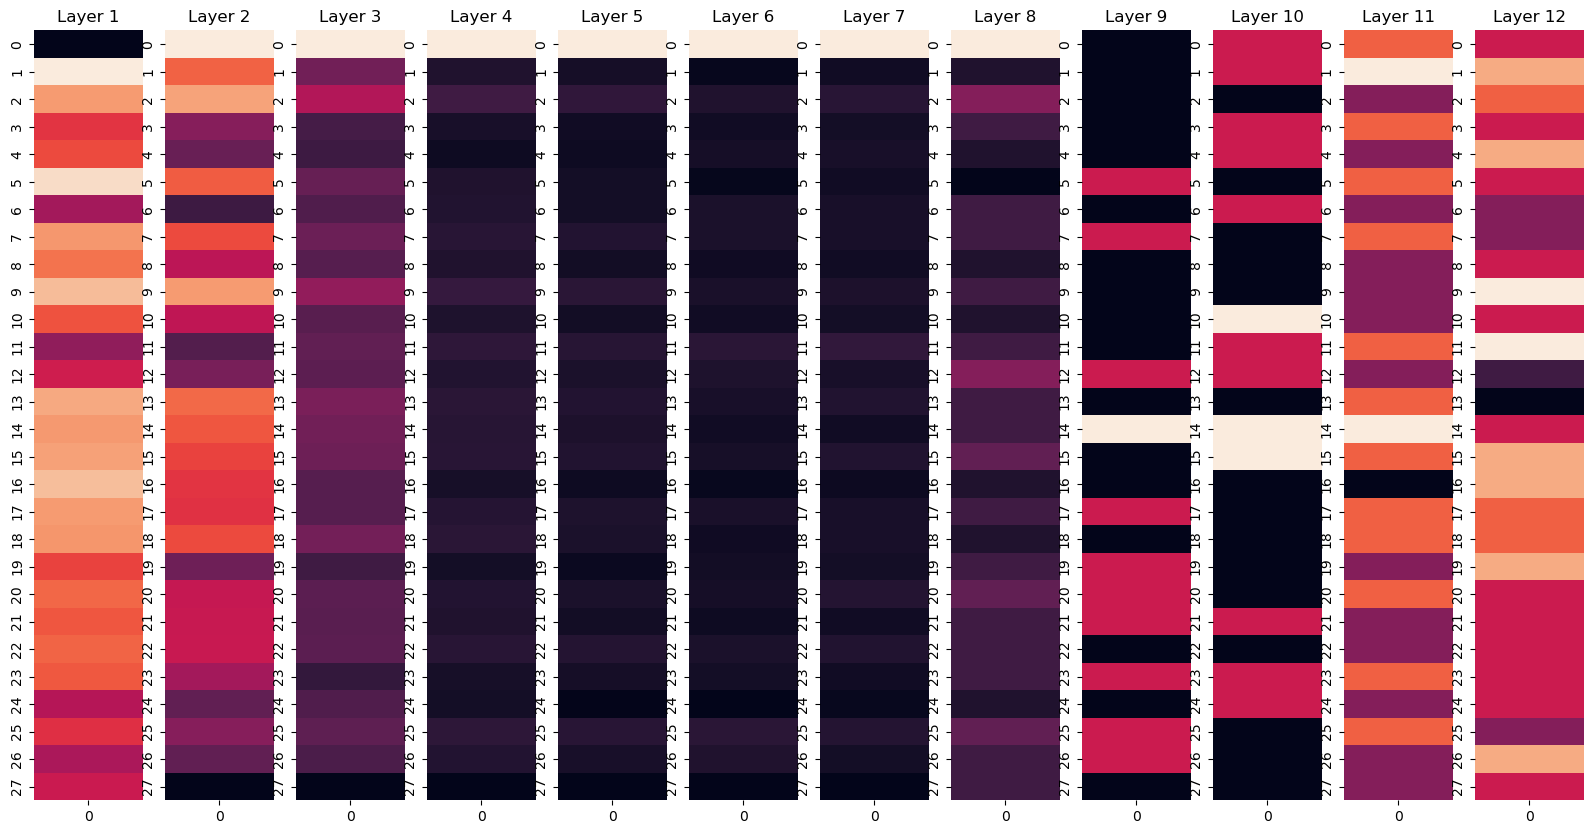

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(42)
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # Change here: make sure to use batch_first=True in the transformer encoder
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, depth, num_heads):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)  # in_channels set to 1 for grayscale
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1)  # Output a single value for regression
        )

    def forward(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer_encoder(x)
        x = self.regression_head(x[:, 0])
        return x

    def get_attention_maps(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        attention_maps = []
        for layer in self.transformer_encoder.layers:
            x = layer.norm1(x)
            attention = layer.self_attn(x, x, x, need_weights=True)[1]
            attention_maps.append(attention.detach().cpu())
            x = layer.self_attn(x, x, x)[0] + x
            x = layer.norm2(x)
            x = layer.linear2(layer.dropout(layer.activation(layer.linear1(x)))) + x
        return attention_maps

class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data_tensor = data_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        sample = self.data_tensor[idx]
        label = self.labels_tensor[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Function to pad the image to the nearest multiple of patch_size_h and patch_size_w
def pad_image(image, patch_size_h, patch_size_w):
    B, C, H, W = image.shape
    pad_h = (patch_size_h - (H % patch_size_h)) % patch_size_h
    pad_w = (patch_size_w - (W % patch_size_w)) % patch_size_w

    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_image = F.pad(image, padding)
    return padded_image

# Define any required transformations
transform = transforms.Compose([
    # Add any transformations you need here
])

data_norm = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_train_02292024.npy'
data_yield = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned/norm_yield_train.npy'

# Load and preprocess data
data = np.load(data_norm)
data_tensor = torch.from_numpy(data).float()  # Convert to float
data_tensor = data_tensor.permute(2, 1, 0)
data_tensor = data_tensor.unsqueeze(1)
data_tensor = pad_image(data_tensor, 216, 8)  # Pad to [batch_size, 1, 216, 8]

labels = np.load(data_yield)
label_tensor = torch.from_numpy(labels).float()  # Convert to float

# Split the data into training, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data_tensor, label_tensor, test_size=0.4, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42)

train_dataset = CustomTensorDataset(data_tensor=train_data, labels_tensor=train_labels, transform=transform)
val_dataset = CustomTensorDataset(data_tensor=val_data, labels_tensor=val_labels, transform=transform)
test_dataset = CustomTensorDataset(data_tensor=test_data, labels_tensor=test_labels, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, generator=g)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, generator=g)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, generator=g)

# Initialize model, loss function, and optimizer
model = VisionTransformer(img_size=(216, 8), patch_size=8, embed_dim=128, depth=12, num_heads=4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
prev_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (inputs, targets) in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # Ensure targets have shape [batch_size, 1]
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % 10 == 0:  # Print every 10 batches
            tqdm.write(f"  Batch {i+1}/{len(train_dataloader)}, Training Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_dataloader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_dataloader, desc="Validation", leave=False)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Ensure targets have shape [batch_size, 1]
            val_loss += loss.item()

            if (i + 1) % 10 == 0:  # Print every 10 batches
                tqdm.write(f"  Batch {i+1}/{len(val_dataloader)}, Validation Loss: {loss.item():.4f}")
    
    avg_val_loss = val_loss / len(val_dataloader)
    gain = prev_val_loss - avg_val_loss
    prev_val_loss = avg_val_loss

    # Print epoch performance
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Gain: {gain:.4f}")

# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader, desc="Testing", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # Ensure targets have shape [batch_size, 1]
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')

# Visualize attention for a single image
model.eval()
single_image, single_label = test_dataset[0]
single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

attention_maps = model.get_attention_maps(single_image)

# Plotting the attention maps
def plot_attention_maps(image, attention_maps):
    fig, axes = plt.subplots(1, len(attention_maps), figsize=(20, 10))
    for i, attn_map in enumerate(attention_maps):
        attn_map = attn_map[0, 0].reshape(28, 1)  # Reshape to match image patches
        sns.heatmap(attn_map.cpu().numpy(), ax=axes[i], cbar=False)
        axes[i].set_title(f'Layer {i+1}')
    plt.show()

plot_attention_maps(single_image, attention_maps)


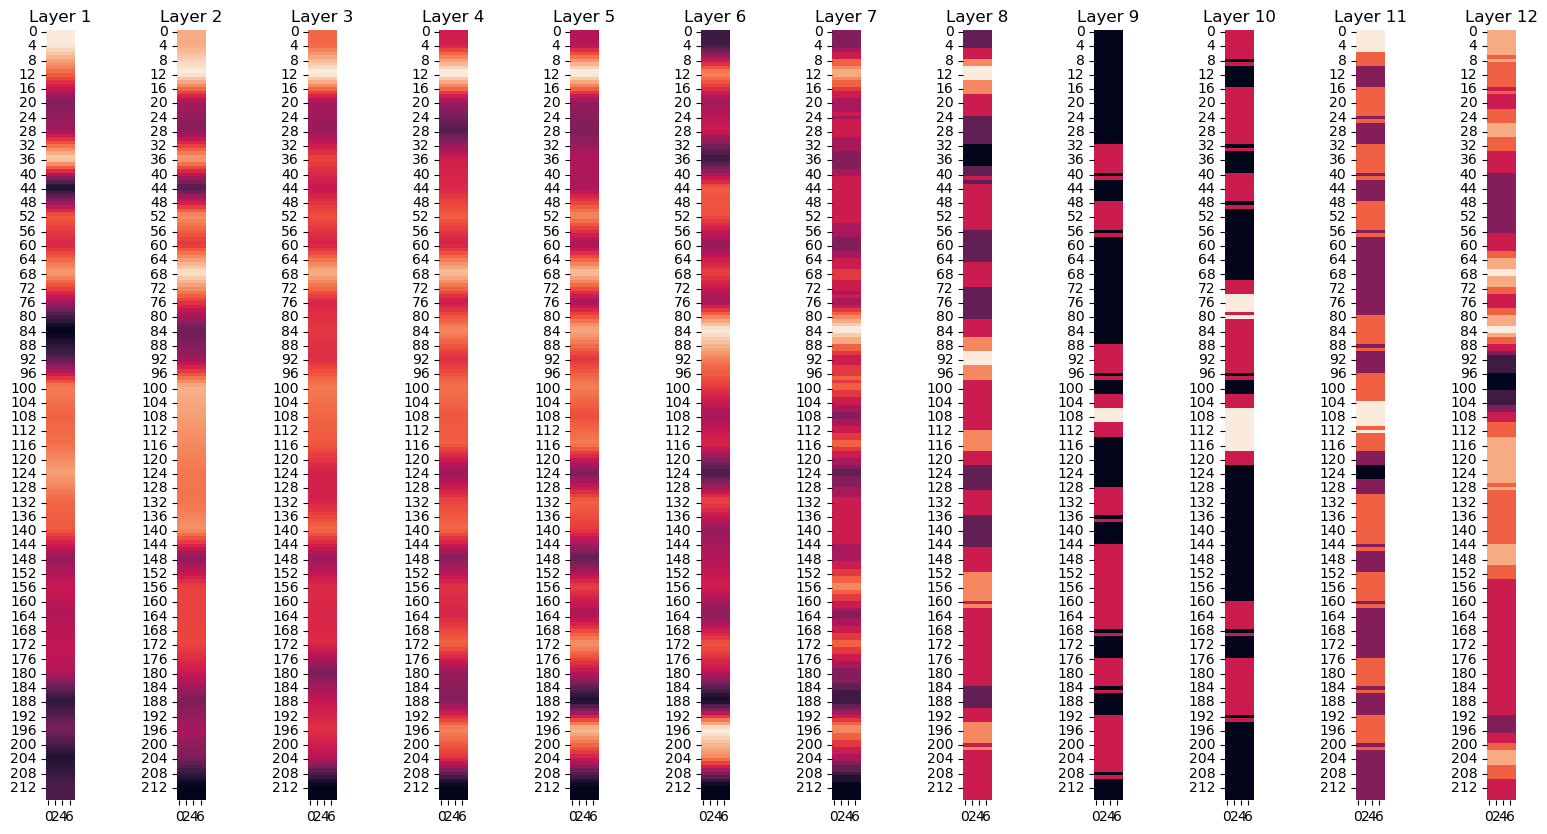

In [15]:
# Visualize attention for a single image
model.eval()
single_image, single_label = test_dataset[0]
single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

attention_maps = model.get_attention_maps(single_image)

# Plotting the attention maps
def plot_attention_maps(image, attention_maps, patch_size=8):
    image = image.squeeze().cpu().numpy()
    fig, axes = plt.subplots(1, len(attention_maps), figsize=(20, 10))
    num_patches = (image.shape[0] // patch_size) * (image.shape[1] // patch_size)
    for i, attn_map in enumerate(attention_maps):
        attn_map = attn_map[0, 0, 1:].reshape(num_patches)  # Ignore the CLS token
        attn_map = attn_map.reshape(image.shape[0] // patch_size, image.shape[1] // patch_size)
        attn_map = F.interpolate(attn_map.unsqueeze(0).unsqueeze(0), size=image.shape, mode='bilinear').squeeze().cpu().numpy()
        sns.heatmap(attn_map, ax=axes[i], cbar=False)
        axes[i].imshow(image, cmap='gray', alpha=0.6)
        axes[i].set_title(f'Layer {i+1}')
    plt.show()

plot_attention_maps(single_image, attention_maps)